# Demonstration notebook for multishapeGP code

**Authors:** Justin Strait (corresponding author: jstrait@lanl.gov) and Hengrui Luo (Rice University, previously Lawrence Berkeley National Laboratory)

## **Copyright notice**

© 2023. Triad National Security, LLC. All rights reserved.
This program was produced under U.S. Government contract 89233218CNA000001 for Los Alamos
National Laboratory (LANL), which is operated by Triad National Security, LLC for the U.S.
Department of Energy/National Nuclear Security Administration. All rights in the program are.
reserved by Triad National Security, LLC, and the U.S. Department of Energy/National Nuclear
Security Administration. The Government is granted for itself and others acting on its behalf a
nonexclusive, paid-up, irrevocable worldwide license in this material to reproduce, prepare.
derivative works, distribute copies to the public, perform publicly and display publicly, and to permit.
others to do so.

## **Description of notebook**

This Jupyter notebook demonstrates use of the proposed single-output and multiple-output GP model for closed curve fitting, with demonstration of benefits to various downstream applications in statistical shape analysis. Functions are demonstrated primarily on two publicly available datasets, listed below:

- MPEG-7 shape dataset: available at https://dabi.temple.edu/external/shape/MPEG7/dataset.html, this dataset is provided as closed curve boundaries for various classes of objects extracted from binary images
- Flavia leaf daataset: available at https://flavia.sourceforge.net/, this dataset is provided as closed curve boundaries for various classes of plant leaves extracted from their corresponding images

These datasets are provided as .npz archived files. Code chunks are labeled according to which figures the code is aimed at reproducing/demonstrating in our currently-in-review manuscript submission "Nonparametric Multi-shape Modeling with Uncertainty Quantification" (https://arxiv.org/abs/2206.09127). Minor differences may result due to random number generation.

### Load associated packages

In [2]:
# Load packages and utility functions
from curveGP import *
from landmarkGP import *
%matplotlib inline
import random
import ot
import scipy as sp

### Load MPEG-7 and Flavia datasets

In [3]:
## Load MPEG-7 curve data
data = np.load('MPEG7.npz', allow_pickle=True)
mpeg_data = data['Xdata']

# Extract curve dimensions
curve = mpeg_data[0,1]  # just arbitrarily subset a class, since all MPEG-7 shape classes are of the same dimension
d1,n_o1 = curve.shape # d is 2 and n_o is the sample of points from the curve. 
m1 = mpeg_data.shape[1]  # number of curves within shape class

In [4]:
## Load Flavia leaf data
data = np.load('flavia_custom.npz', allow_pickle=True)
flav_data = data['Xdata']

# Extract curve dimensions
curve = flav_data[0,1,:,:] 
d2,n_o2 = curve.shape # d is 2 and n_o is the sample of points from the curve. 
m2 = flav_data.shape[1]  # number of curves within shape class

### Single-output GP fitting (Figure 1)

In [5]:
# Save curves within specified shape class to a single array
# shape_idx - index of shape class (see MPEG_key.txt for index labels)
shape_idx = 0
n = n_o1+1  # number of sample points for each curve when first point = last point (since closed)
beta = np.zeros((d1,n,m1))
beta_sc = np.zeros((d1,n,m1))

# Apply rotation matrix
theta = np.radians(30)
O = np.array(((np.cos(theta),-np.sin(theta)), (np.sin(theta),np.cos(theta))))

# Original curves re-scaled to unit length and (0,0)-centered
for i in range(0,m1):
    beta[:,0:n_o1,i] = np.matmul(O,mpeg_data[shape_idx,i])
    beta[:,n_o1,i] = beta[:,0,i]
    beta_sc[:,:,i] = cf.scale_curve(beta[:,:,i])[0]
    tmp = cf.calculatecentroid(beta_sc[:,:,i])
    beta_sc[:,:,i] = beta_sc[:,:,i]-np.transpose(np.tile(tmp,(n,1)))

In [6]:
# Prepare data (list format)
exCURVES_obs = []
exCURVES_truth = []

# Curves
N_obs = 15
samp_idx = np.round(np.linspace(0,n_o1,N_obs)).astype(int)
exCURVES_obs.append(beta_sc[:,samp_idx,0])
exCURVES_truth.append(beta_sc[:,:,0])

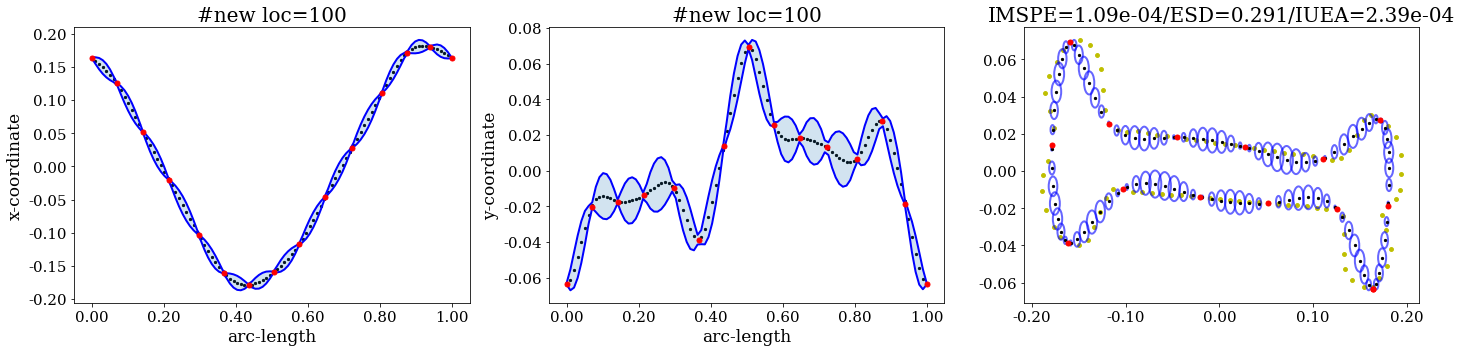

In [7]:
# SOGP fit
SOGP_fig1 = curveSOGP(datapoint=exCURVES_obs[0], predpoint=100, truthpoint=exCURVES_truth[0], cen=True, scale=True, 
                      nug=1e-3, showOutput=False, restrict_nv=False, showCoord=True)

### Tradeoff of periodicity and length scale hyperparameters (Figure 2)

In [8]:
# Save curves within specified shape class to a single array, and compute SRVF
# shape_idx - index of shape class (see MPEG_key.txt for index labels)
shape_idx = 0
n = n_o1+1  # number of sample points for each curve when first point = last point (since closed)
beta = np.zeros((d1,n,m1))
beta_sc = np.zeros((d1,n,m1))

# Apply rotation matrix
theta = np.radians(30)
O = np.array(((np.cos(theta),-np.sin(theta)), (np.sin(theta),np.cos(theta))))

# Original curves re-scaled to unit length and (0,0)-centered
for i in range(0,m1):
    beta[:,0:n_o1,i] = np.matmul(O,mpeg_data[shape_idx,i])
    beta[:,n_o1,i] = beta[:,0,i]
    beta_sc[:,:,i] = cf.scale_curve(beta[:,:,i])[0]
    tmp = cf.calculatecentroid(beta_sc[:,:,i])
    beta_sc[:,:,i] = beta_sc[:,:,i]-np.transpose(np.tile(tmp,(n,1)))

In [9]:
# Prepare data (list format)
exCURVES_obs = []
exCURVES_truth = []
predList = []

# Curves
N_obs = 15
curve_idx = np.round(np.linspace(0,n_o1,N_obs)).astype(int)
exCURVES_truth.append(beta_sc[:,:,8])
exCURVES_obs.append(beta_sc[:,curve_idx,8])

>>length of curve 0.9999999999999998
>>restrictLS= False
>>period= 0.9999999999999998
      fun: -19.04370886298849
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 5.08645595e-03, -3.12134162e-04, -7.56644404e-05, -9.41384326e-03])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 39
      nit: 25
     njev: 39
   status: 0
  success: True
        x: array([ 0.38945688, -1.04216803, -4.58460334, -2.17985733])
      fun: -36.078460737231836
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.47781074e-01, -5.70251536e-04,  6.45666360e-04,  8.83226752e-07])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 84
      nit: 56
     njev: 84
   status: 0
  success: True
        x: array([  0.54133096,  -1.27167359,  -6.71326123, -17.84223119])


Optimizer: L-BFGS-B loglik_margX:  19.0437 loglik_margY:  36.0785


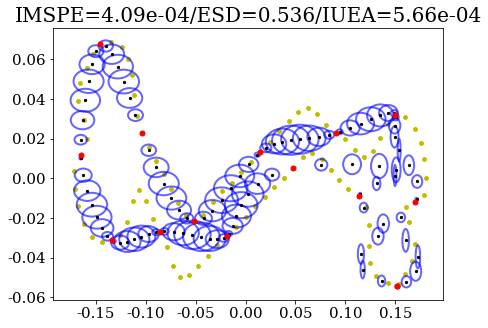

In [10]:
# (1) SOGP fit: period estimated, LS unconstrained
SOGP1_fig2 = curveSOGP(datapoint=exCURVES_obs[0], predpoint=100, truthpoint=exCURVES_truth[0], cen=True, scale=True,
                       est_period=True, restrictLS=False, nug=1e-3, showOutput=True, restrict_nv=True)

>>length of curve 0.9999999999999998
>>restrictLS= False
>>period= 0.9999999999999998
      fun: -44.7690419395674
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.52580469e-07,  7.26473127e-07,  1.10466813e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 30
      nit: 25
     njev: 30
   status: 0
  success: True
        x: array([  6.79944237,  -0.76538411, -17.62502365])
      fun: -36.078444695729026
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 4.34387051e-06, -3.55689358e-06,  1.00350086e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 35
      nit: 22
     njev: 35
   status: 0
  success: True
        x: array([ -1.27168881,  -6.71336358, -17.71459283])


Optimizer: L-BFGS-B loglik_margX:  44.7690 loglik_margY:  36.0784


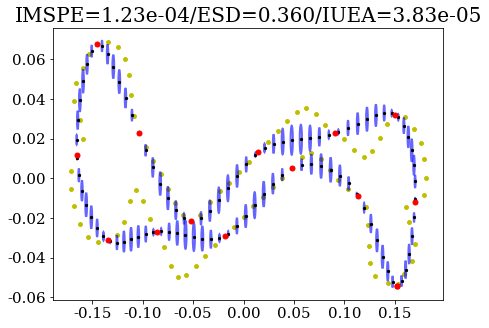

In [11]:
# (2) SOGP fit: period fixed, LS unconstrained
SOGP2_fig2 = curveSOGP(datapoint=exCURVES_obs[0], predpoint=100, truthpoint=exCURVES_truth[0], cen=True, scale=True,  
                       est_period=False, restrictLS=False, nug=1e-3, showOutput=True, restrict_nv=True)

>>length of curve 0.9999999999999998
>>restrictLS= True
>>period= 0.9999999999999998
      fun: -32.61530549686639
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.06014293e-08,  5.15071740e-05,  4.10727850e-10])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 35
      nit: 29
     njev: 35
   status: 0
  success: True
        x: array([ 19.326464  ,  -5.26528404, -25.51727195])
      fun: -36.07844524553903
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.58253747e-04, -7.67220689e-04,  4.09468551e-07])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 42
      nit: 31
     njev: 42
   status: 0
  success: True
        x: array([ -0.02289435,  -6.71348282, -18.61098384])


Optimizer: L-BFGS-B loglik_margX:  32.6153 loglik_margY:  36.0784


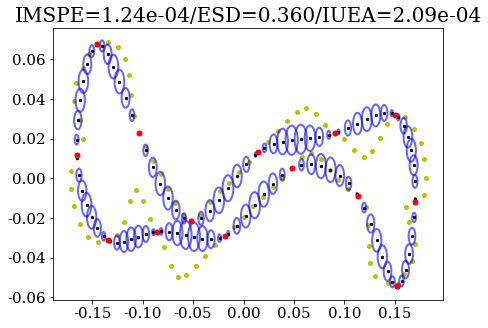

In [12]:
# (3) SOGP fit: period fixed, LS constrained
SOGP3_fig2 = curveSOGP(datapoint=exCURVES_obs[0], predpoint=100, truthpoint=exCURVES_truth[0], cen=True, scale=True, 
                       est_period=False, restrictLS=True, nug=1e-3, showOutput=True, restrict_nv=True)

### Effect of periodicity specification on GP fits (Figure 18)

In [13]:
# Save curves within specified shape class to a single array, and compute SRVF
# shape_idx - index of shape class (see MPEG_key.txt for index labels)
shape_idx = 13
n = n_o1+1  # number of sample points for each curve when first point = last point (since closed)
beta = np.zeros((d1,n,m1))
beta_sc = np.zeros((d1,n,m1))

# Apply rotation matrix
theta = np.radians(270)
O = np.array(((np.cos(theta),-np.sin(theta)), (np.sin(theta),np.cos(theta))))

# Original curves re-scaled to unit length and (0,0)-centered
for i in range(0,m1):
    beta[:,0:n_o1,i] = np.matmul(O,mpeg_data[shape_idx,i])
    beta[:,n_o1,i] = beta[:,0,i]
    beta_sc[:,:,i] = cf.scale_curve(beta[:,:,i])[0]
    tmp = cf.calculatecentroid(beta_sc[:,:,i])
    beta_sc[:,:,i] = beta_sc[:,:,i]-np.transpose(np.tile(tmp,(n,1)))

In [14]:
# Prepare data (list format)
exCURVES_obs = []
exCURVES_truth = []
predList = []

# Curves
N_obs = 20
curve_idx = np.round(np.linspace(0,n_o1,N_obs)).astype(int)
exCURVES_truth.append(beta_sc[:,:,5])
exCURVES_obs.append(beta_sc[:,curve_idx,5])

/Users/jstrait/opt/anaconda3/lib/python3.8/site-packages/fdasrsf/curve_functions.py:115: RuntimeWarning: invalid value encountered in true_divide
  q = q / lenq


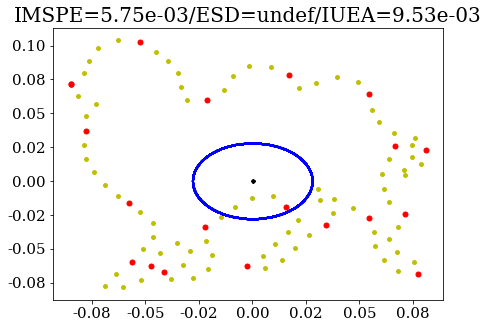

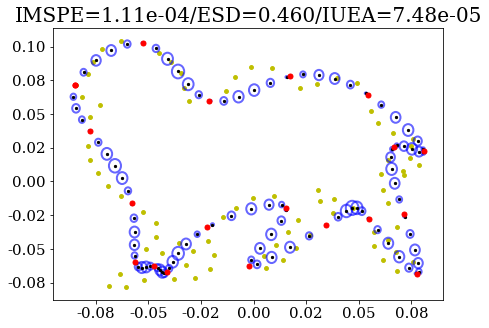

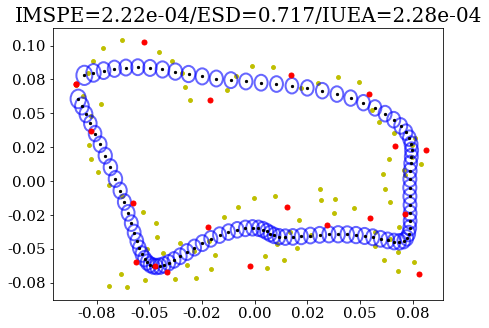

In [15]:
# SOGP fit varying PERIOD_mult
period_mult = [0.5,1,1.5]
for i in range(len(period_mult)):
    SOGP_fig3 = curveSOGP(datapoint=exCURVES_obs[0], predpoint=100, truthpoint=exCURVES_truth[0],
                          period_mult=period_mult[i], restrictLS=True, nug=1e-4, showPlot=True, showOutput=False, 
                          restrict_nv=False)

### Figure 11

In [16]:
# Save curves within specified shape class to a single array, and compute SRVF
# shape_idx - index of shape class (see MPEG_key.txt for index labels)
shape_idx = 0
n = n_o1+1  # number of sample points for each curve when first point = last point (since closed)
beta = np.zeros((d1,n,m1))
beta_sc = np.zeros((d1,n,m1))

# Apply rotation matrix
theta = np.radians(30)
O = np.array(((np.cos(theta),-np.sin(theta)), (np.sin(theta),np.cos(theta))))

# Original curves re-scaled to unit length and (0,0)-centered
for i in range(0,m1):
    beta[:,0:n_o1,i] = np.matmul(O,mpeg_data[shape_idx,i])
    beta[:,n_o1,i] = beta[:,0,i]
    beta_sc[:,:,i] = cf.scale_curve(beta[:,:,i])[0]
    tmp = cf.calculatecentroid(beta_sc[:,:,i])
    beta_sc[:,:,i] = beta_sc[:,:,i]-np.transpose(np.tile(tmp,(n,1)))

In [17]:
# Prepare data (list format)
exCURVES_obs = []
exCURVES_truth = []

# Curves
# All equally-spaced, vary number of points
for i in range(0,3):
    N_obs = 15+i*5
    samp_idx = np.round(np.linspace(0,n_o1,N_obs)).astype(int)
    exCURVES_obs.append(beta_sc[:,samp_idx,0])
    exCURVES_truth.append(beta_sc[:,:,0])

# Equally-spaced vs. clumped
for i in range(0,3):
    if i==0:
        N_obs = 15
        samp_idx = np.round(np.linspace(0,n_o1,N_obs)).astype(int)
    elif i==1:
        samp_idx = [0,2,4,6,8,10,12,14,16,18,20,48,66,84,100]
    else:
        samp_idx = [0,24,45,47,49,51,53,55,57,59,61,63,65,67,89]
    exCURVES_obs.append(beta_sc[:,samp_idx,0])
    exCURVES_truth.append(beta_sc[:,:,0])

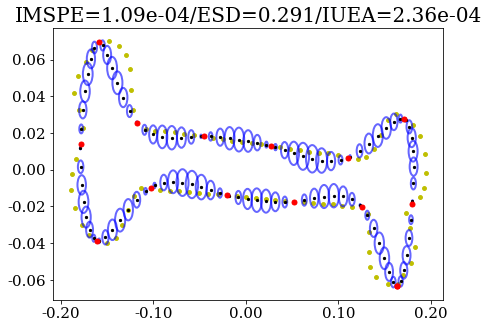

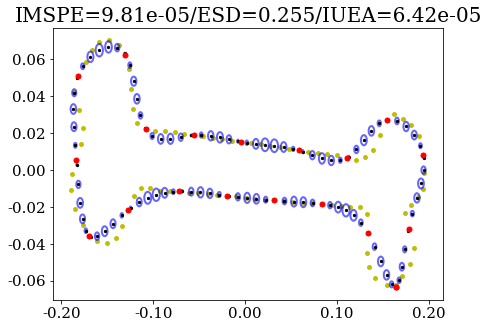

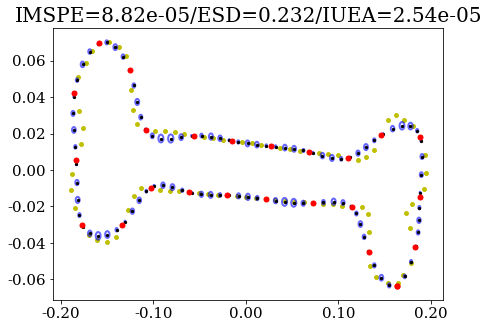

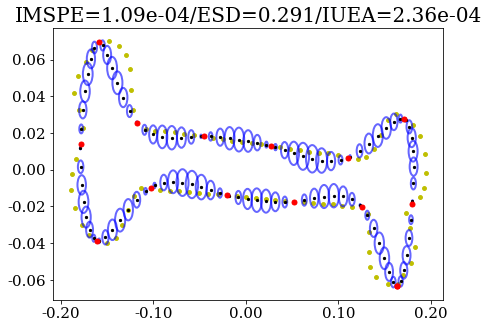

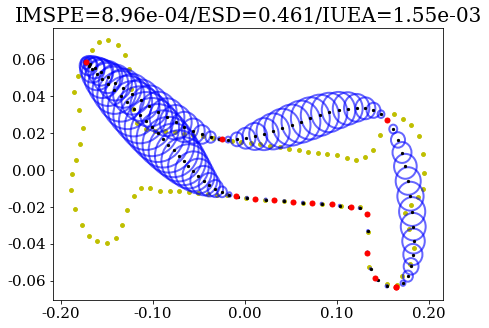

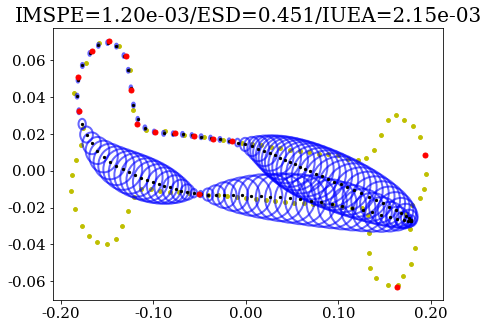

In [18]:
# SOGP fits
for i in range(0,6):
    SOGP_fig4 = curveSOGP(datapoint=exCURVES_obs[i], predpoint=100, truthpoint=exCURVES_truth[i], cen=True, scale=True, 
                          showOutput=False, nug=1e-3, restrict_nv=True)

### Comparing base kernel choices, including stationary vs. non-stationary, for single-output GP fitting (Figure 13)

In [19]:
# Save curves within specified shape class to a single array, and compute SRVF
# shape_idx - index of shape class (see MPEG_key.txt for index labels)
shape_idx = 12
n = n_o1+1  # number of sample points for each curve when first point = last point (since closed)
beta = np.zeros((d1,n,m1))
beta_sc = np.zeros((d1,n,m1))

# Apply rotation matrix
theta = np.radians(270)
O = np.array(((np.cos(theta),-np.sin(theta)), (np.sin(theta),np.cos(theta))))

# Original curves re-scaled to unit length and (0,0)-centered
for i in range(0,m1):
    beta[:,0:n_o1,i] = np.matmul(O,mpeg_data[shape_idx,i])
    beta[:,n_o1,i] = beta[:,0,i]
    beta_sc[:,:,i] = cf.scale_curve(beta[:,:,i])[0]
    tmp = cf.calculatecentroid(beta_sc[:,:,i])
    beta_sc[:,:,i] = beta_sc[:,:,i]-np.transpose(np.tile(tmp,(n,1)))

In [20]:
# Prepare data (list format)
exCURVES_obs = []
exCURVES_truth = []

# Curves
N_obs = 15
curve_idx = np.round(np.linspace(0,n_o1,N_obs)).astype(int)
idx = 0

np.random.seed(101)

tmp = beta_sc[:,:,idx]
tmp = tmp + np.random.normal(0, 0.008, size=((2,101)))
tmp[:,-1] = tmp[:,0]
exCURVES_obs.append(tmp[:,curve_idx])
exCURVES_truth.append(beta_sc[:,:,idx])

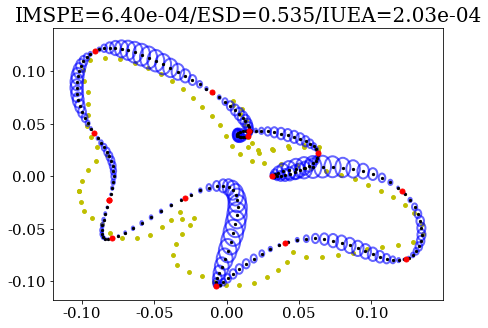

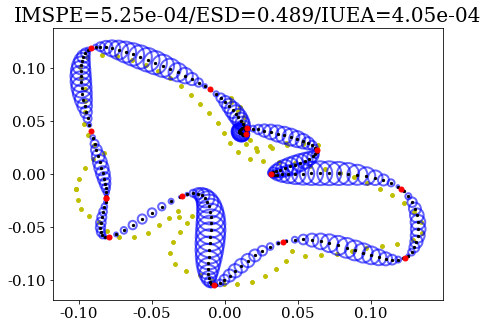

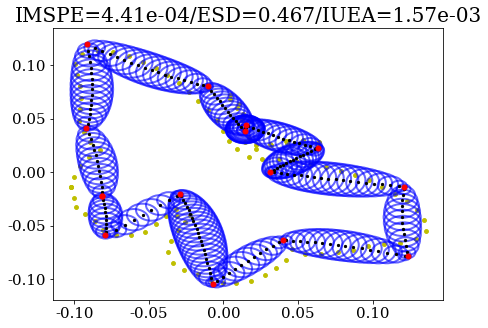

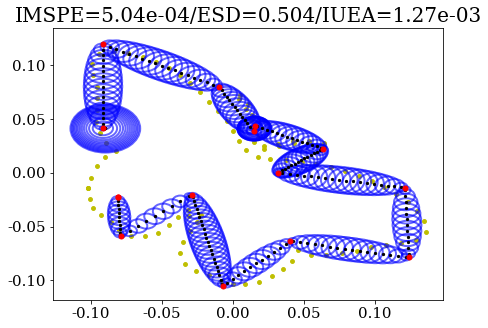

In [21]:
# Try various periodic stationary kernels (Figure 5) and non-stationary kernel (Figure 17)
kern = ['SqExp','Matern32','Matern12','Arccos']
for ker in kern:
    SOGP_fig517 = curveSOGP(datapoint=exCURVES_obs[0], predpoint=200, truthpoint=exCURVES_truth[0], cen=True, scale=True, 
                            showOutput=False, nug=1e-3, kernel=ker, restrict_nv=True)

### Comparison of single-output, multiple-output GP fits, latter with and without ANOVA-style kernel (figure omitted in current manuscript submission)

In [22]:
# Save curves within specified shape class to a single array, and compute SRVF
# shape_idx - index of shape class (see MPEG_key.txt for index labels)
shape_idx = 0
n = n_o1+1  # number of sample points for each curve when first point = last point (since closed)
beta = np.zeros((d1,n,m1))
beta_sc = np.zeros((d1,n,m1))

# Apply rotation matrix
theta = np.radians(30)
O = np.array(((np.cos(theta),-np.sin(theta)), (np.sin(theta),np.cos(theta))))

# Original curves re-scaled to unit length and (0,0)-centered
for i in range(0,m1):
    beta[:,0:n_o1,i] = np.matmul(O,mpeg_data[shape_idx,i])
    beta[:,n_o1,i] = beta[:,0,i]
    beta_sc[:,:,i] = cf.scale_curve(beta[:,:,i])[0]
    tmp = cf.calculatecentroid(beta_sc[:,:,i])
    beta_sc[:,:,i] = beta_sc[:,:,i]-np.transpose(np.tile(tmp,(n,1)))

In [23]:
# Prepare data (list format)
exCURVES_obs = []
exCURVES_truth = []

# Curves
N_obs = 15
samp_idx = np.round(np.linspace(0,n_o1,N_obs)).astype(int)
exCURVES_obs.append(beta_sc[:,samp_idx,0])
exCURVES_truth.append(beta_sc[:,:,0])

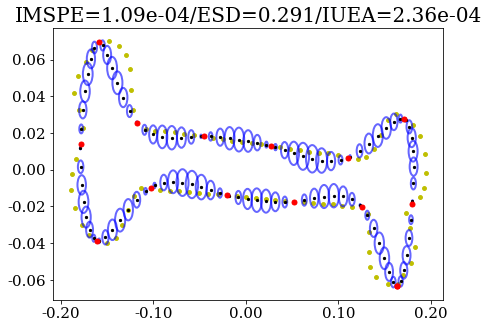

In [24]:
# SOGP fit
SOGP_fig6 = curveSOGP(datapoint=exCURVES_obs[0], predpoint=100, truthpoint=exCURVES_truth[0], cen=True, scale=True, nug=1e-3, 
                      showOutput=False, restrict_nv=True)

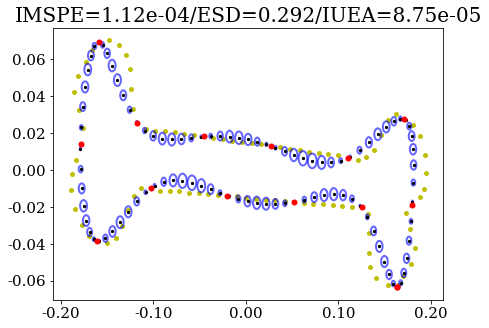

In [25]:
# MOGP fit
MOGP_fig6 = curveBatchMOGP(datapointList=[exCURVES_obs[0]], predList=100, truthpointList=[exCURVES_truth[0]], cen=True, 
                           scale=True, rot=False, nug=1e-3, showOutput=False, restrict_nv=True)

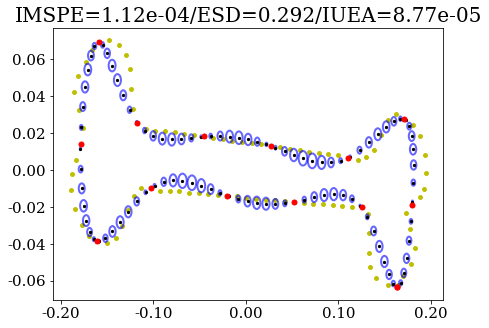

In [26]:
# MOGP fit, ANOVA style
MOGP_fig6a = curveBatchMOGP(datapointList=[exCURVES_obs[0]], predList=100, truthpointList=[exCURVES_truth[0]], cen=True, 
                            scale=True, rot=False, nug=1e-3, showOutput=False, restrict_nv=True, anova_style=True)

### Comparing single-output and multiple-output GP fits, the latter with and without rotational alignment pre-processing and with and without ANOVA-style kernel (Figure 3)

In [27]:
# Save curves within specified shape class to a single array, and compute SRVF
# shape_idx - index of shape class (see MPEG_key.txt for index labels)
shape_idx = 13
n = n_o1+1  # number of sample points for each curve when first point = last point (since closed)
beta = np.zeros((d1,n,m1))
beta_sc = np.zeros((d1,n,m1))

# Apply rotation matrix
theta = np.radians(270)
O = np.array(((np.cos(theta),-np.sin(theta)), (np.sin(theta),np.cos(theta))))

# Original curves re-scaled to unit length and (0,0)-centered
for i in range(0,m1):
    beta[:,0:n_o1,i] = np.matmul(O,mpeg_data[shape_idx,i])
    beta[:,n_o1,i] = beta[:,0,i]
    beta_sc[:,:,i] = cf.scale_curve(beta[:,:,i])[0]
    tmp = cf.calculatecentroid(beta_sc[:,:,i])
    beta_sc[:,:,i] = beta_sc[:,:,i]-np.transpose(np.tile(tmp,(n,1)))

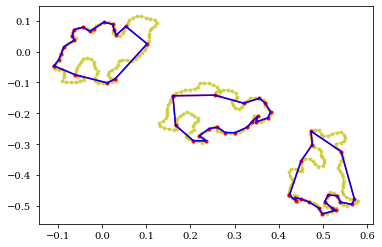

In [28]:
# Prepare data (list format)
exCURVES_obs = []
exCURVES_truth = []

# Curves
N_obs = 20
idx = [1,2,15]
for i in range(0,3):
    if i==0:
        theta = np.radians(0)
        O = np.array(((np.cos(theta),-np.sin(theta)), (np.sin(theta),np.cos(theta))))
        curve_idx = np.hstack( (np.round(np.linspace(0,28,N_obs-6)), np.round(np.linspace(32,64,3)), np.round(np.linspace(67,100,3))) )
    elif i==1:
        theta = np.radians(330)
        O = np.array(((np.cos(theta),-np.sin(theta)), (np.sin(theta),np.cos(theta))))
        curve_idx = np.hstack( (np.round(np.linspace(0,28,3)), np.round(np.linspace(32,64,N_obs-6)), np.round(np.linspace(67,100,3))) )
    else:
        theta = np.radians(30)
        O = np.array(((np.cos(theta),-np.sin(theta)), (np.sin(theta),np.cos(theta))))
        curve_idx = np.hstack( (np.round(np.linspace(0,28,3)), np.round(np.linspace(32,64,3)), np.round(np.linspace(67,100,N_obs-6))) )
        
    exCURVES_obs.append(O@beta_sc[:,curve_idx.astype(int),idx[i]])
    exCURVES_truth.append(O@beta_sc[:,:,idx[i]])
    
# Plot original curves
x_offset = 0.25
y_offset = 0.2
for i in range(0,len(exCURVES_obs)):
    plt.plot(exCURVES_truth[i][0,:]+x_offset*i, exCURVES_truth[i][1,:]-y_offset*i, c='y', marker='.', alpha=0.5)
    plt.plot(exCURVES_obs[i][0,:]+x_offset*i, exCURVES_obs[i][1,:]-y_offset*i, c='r', marker='.')
    plt.plot(exCURVES_obs[i][0,:]+x_offset*i, exCURVES_obs[i][1,:]-y_offset*i, c='b')

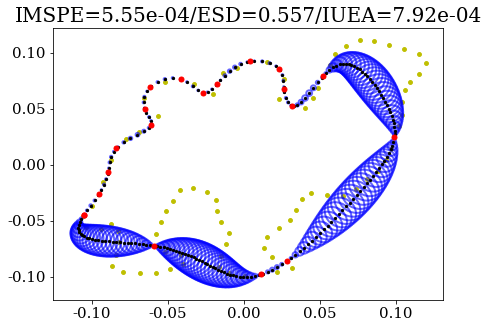

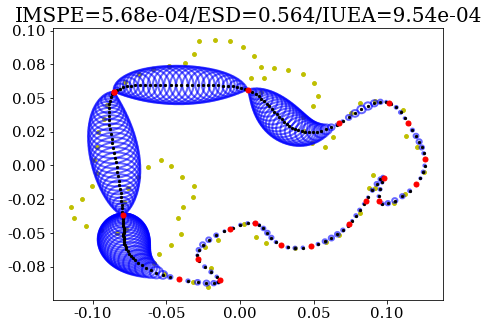

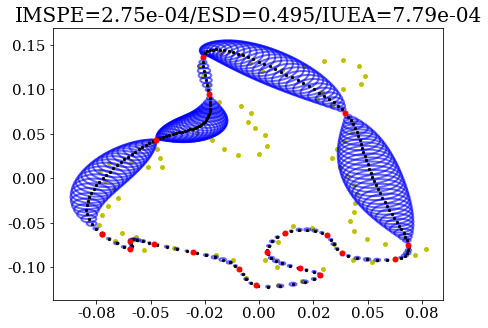

In [29]:
# (1) Separate SOGP fits, no rotation
for i in range(0,3):
    MOGP1_fig7 = curveSOGP(datapoint=exCURVES_obs[i], predpoint=200, truthpoint=exCURVES_truth[i], cen=True, 
                           scale=True, nug=1e-2, showOutput=False, kernel='Matern32', restrict_nv=True)

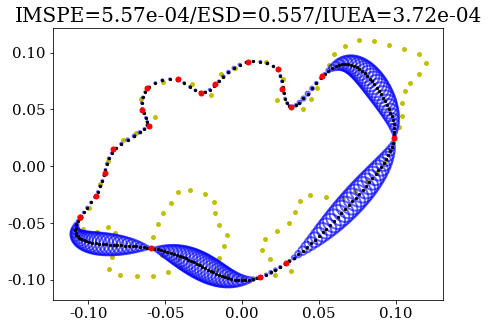

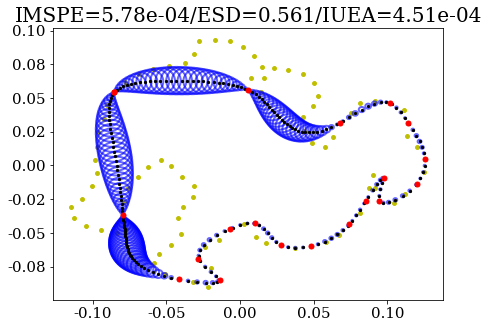

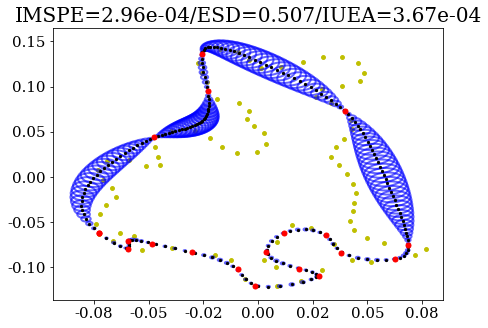

In [30]:
# (2) Separate MOGP fits, no rotation
for i in range(0,3):
    MOGP2_fig7 = curveBatchMOGP(datapointList=[exCURVES_obs[i]], predList=200, truthpointList=[exCURVES_truth[i]], cen=True, 
                                scale=True, rot=False, nug=1e-2, showOutput=False, kernel='Matern32', restrict_nv=True)

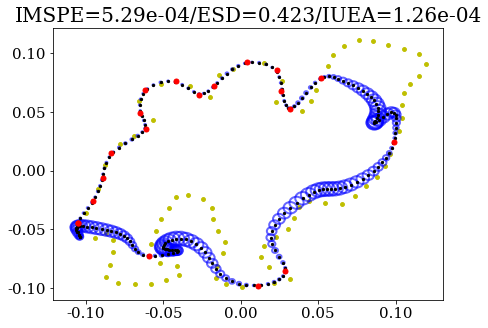

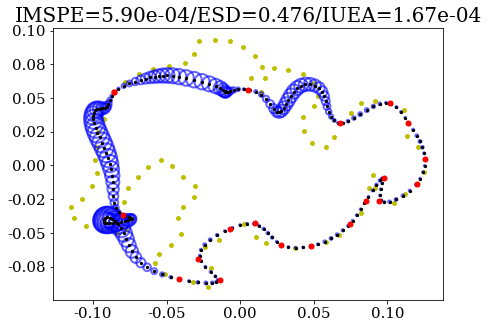

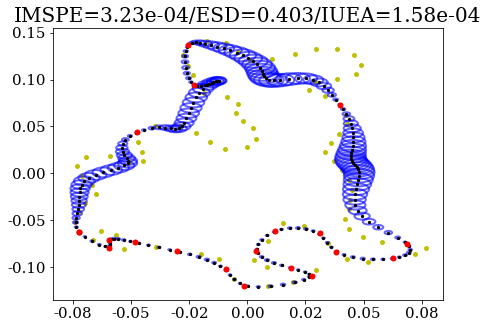

In [31]:
# (3) Joint MOGP fit, no rotation
MOGP3_fig7 = curveBatchMOGP(datapointList=exCURVES_obs, predList=200, truthpointList=exCURVES_truth, cen=True, scale=True, 
                            rot=False, nug=1e-2, showOutput=False, kernel='Matern32', restrict_nv=True)

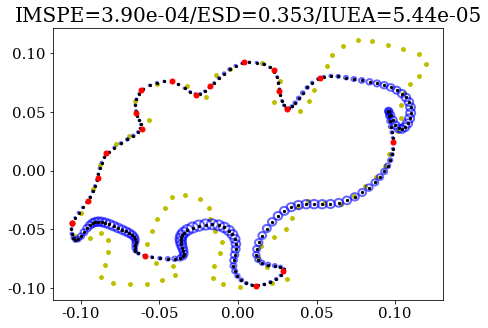

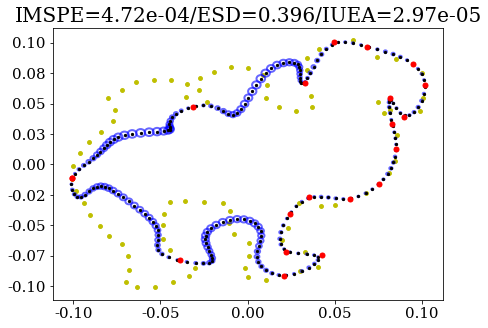

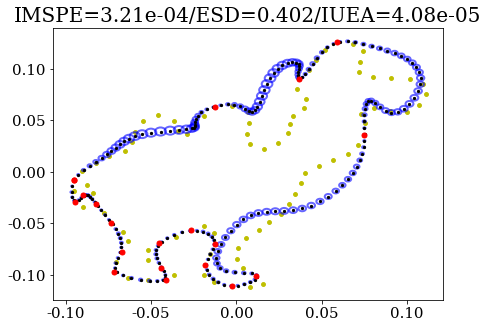

In [32]:
# (4) Joint MOGP fit, rotation pre-processing
MOGP4_fig7 = curveBatchMOGP(datapointList=exCURVES_obs, predList=200, truthpointList=exCURVES_truth, cen=True, scale=True, 
                            rot=True, nug=1e-2, showOutput=False, kernel='Matern32', restrict_nv=True)

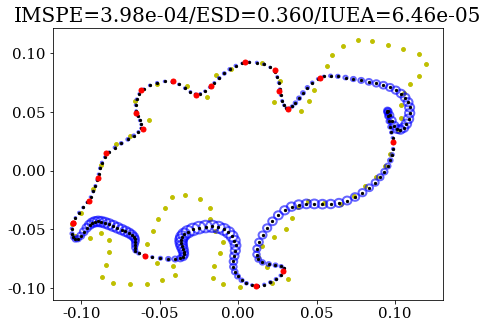

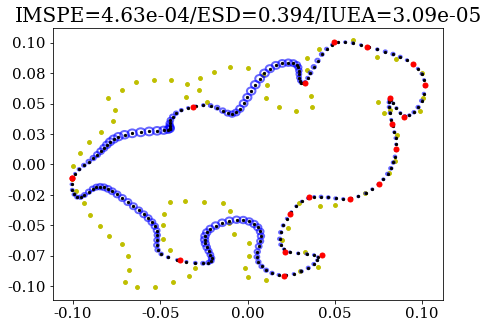

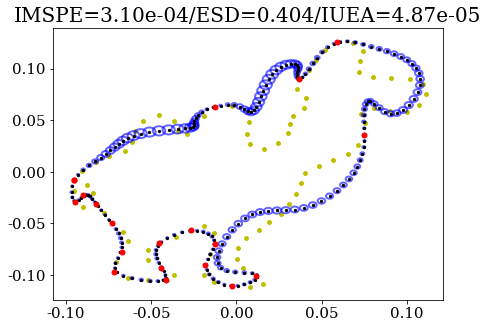

In [33]:
# (4a) Joint MOGP fit, rotation pre-processing (ANOVA style)
MOGP4_fig7a = curveBatchMOGP(datapointList=exCURVES_obs, predList=200, truthpointList=exCURVES_truth, cen=True, scale=True, 
                             rot=True, nug=1e-2, showOutput=False, kernel='Matern32', restrict_nv=True, anova_style=True)

### Demonstrating the sharing of structural similarity for multiple-output GP fits (figure omitted in current manuscript submission)

In [34]:
# Save curves within specified shape class to a single array, and compute SRVF
# shape_idx - index of shape class (see MPEG_key.txt for index labels)
shape_idx = 13
n = n_o1+1  # number of sample points for each curve when first point = last point (since closed)
beta = np.zeros((d1,n,m1))
beta_sc = np.zeros((d1,n,m1))

# Apply rotation matrix
theta = np.radians(300)
O = np.array(((np.cos(theta),-np.sin(theta)), (np.sin(theta),np.cos(theta))))

# Original curves re-scaled to unit length and (0,0)-centered
for i in range(0,m1):
    beta[:,0:n_o1,i] = np.matmul(O,mpeg_data[shape_idx,i])
    beta[:,n_o1,i] = beta[:,0,i]
    beta_sc[:,:,i] = cf.scale_curve(beta[:,:,i])[0]
    tmp = cf.calculatecentroid(beta_sc[:,:,i])
    beta_sc[:,:,i] = beta_sc[:,:,i]-np.transpose(np.tile(tmp,(n,1)))

In [35]:
# Prepare data (list format)
exCURVES_truth = []
exCURVES_obs = []

# Curve
N_obs = 25
for i in range(0,3):
    # Curve indices to extract for observed curves and parameter values to predict curves at
    if i==0:
        curve_idx = [0,4,8,12,16,20,24,28,32,36,39,100]
    else:
        curve_idx = np.round(np.linspace(0,n_o1,N_obs)).astype(int)
    exCURVES_truth.append(beta_sc[:,:,i])
    exCURVES_obs.append(beta_sc[:,curve_idx,i])

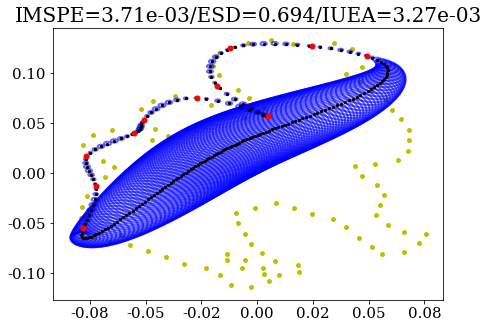

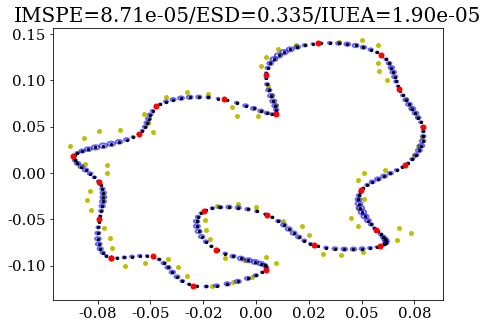

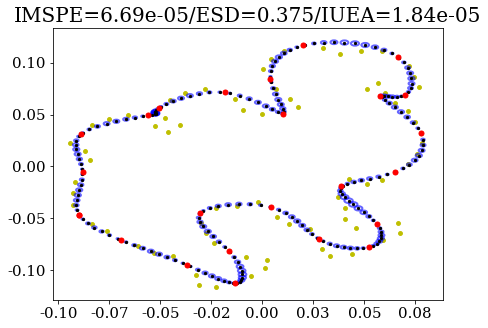

In [36]:
# Separate MOGP fits
for i in range(0,3):
    MOGP1_fig8 = curveBatchMOGP(datapointList=[exCURVES_obs[i]], predList=200, truthpointList=[exCURVES_truth[i]], cen=True, 
                                scale=True, rot=False, nug=1e-3, showOutput=False, kernel='Matern32', restrict_nv=False)

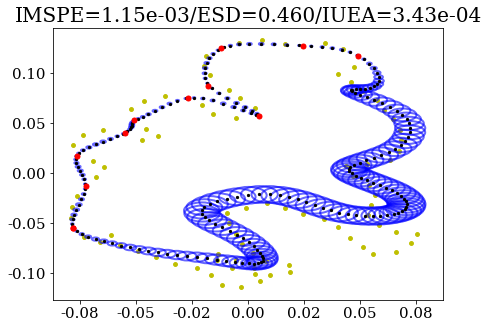

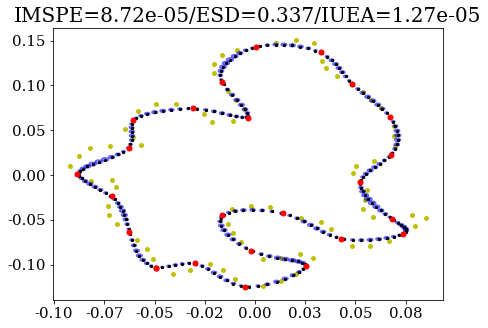

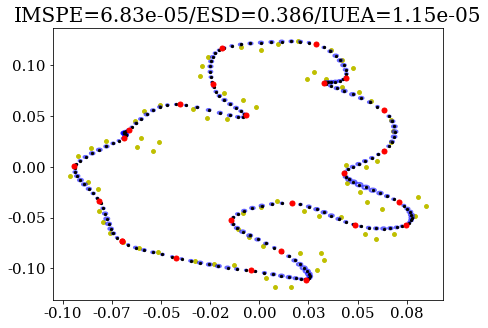

In [37]:
# Joint MOGP fit
MOGP2_fig8 = curveBatchMOGP(datapointList=exCURVES_obs, predList=200, truthpointList=exCURVES_truth, cen=True, scale=True, 
                            rot=True, nug=1e-3, showOutput=False, kernel='Matern32', restrict_nv=False)

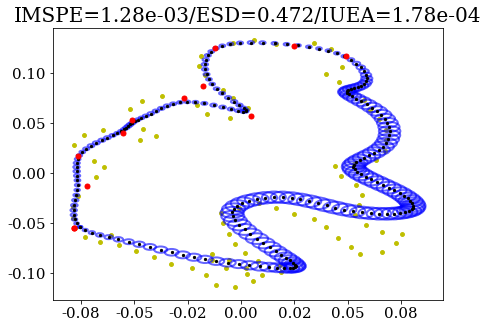

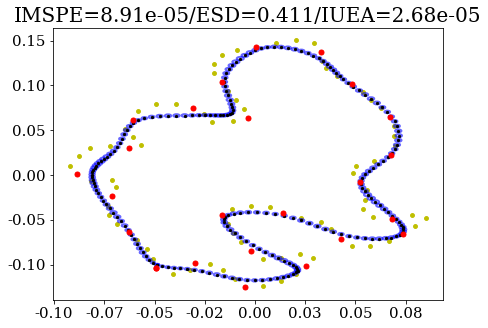

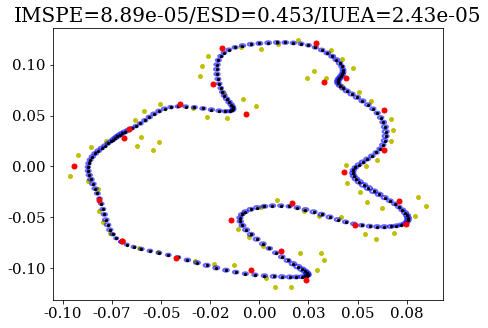

In [38]:
# Joint MOGP fit (ANOVA style)
MOGP2_fig8a = curveBatchMOGP(datapointList=exCURVES_obs, predList=200, truthpointList=exCURVES_truth, cen=True, scale=True, 
                             rot=True, nug=1e-3, showOutput=False, kernel='Matern32', restrict_nv=False, anova_style=True)

### Comparing various shape mean summaries with and without GP fitting, under various sampling schemes and with or without noise (Figure 4)

In [39]:
# Save curves within specified shape class to a single array, and compute SRVF
n = n_o2+1  # number of sample points for each curve when first point = last point (since closed)

# Apply rotation matrix (to test coregionalization model specifications)
theta = np.radians(180)  # change to 30 for horizontal bone, 315 for vertical bone
O = np.array(((np.cos(theta),-np.sin(theta)), (np.sin(theta),np.cos(theta))))

(-0.17365463276728083,
 0.7908947377592435,
 -0.11745938504731593,
 0.1475156205249111)

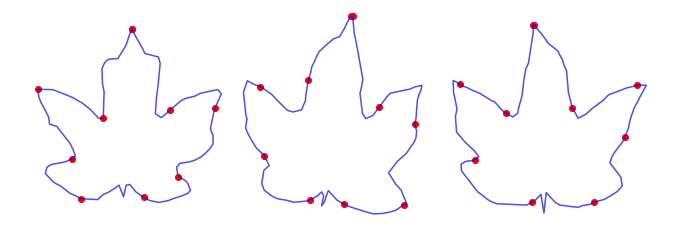

In [40]:
## Panel (a): no noise, n=10
# Original curves re-scaled to unit length and (0,0)-centered
exCURVES_obs = []
exCURVES_truth = []
curve_idx = [0,1,2]
N_obs = 10
pt_idx = np.round(np.linspace(0,n_o2-1,N_obs)).astype(int)
ctr = 0
for idx in curve_idx:
    beta = np.matmul(O,flav_data[0,idx,:,:])
    beta = np.hstack((beta,beta[:,0].reshape(-1,1)))
    beta_sc = cf.scale_curve(beta)[0]
    tmp = cf.calculatecentroid(beta_sc)
    beta_sc = beta_sc-np.transpose(np.tile(tmp,(n_o2+1,1)))
        
    exCURVES_obs.append(beta_sc[:,pt_idx])
    exCURVES_truth.append(beta_sc)
    
plt.figure(figsize=(12,4))
for i in range(3):
    plt.plot(exCURVES_truth[i][0,:]+0.3*i, exCURVES_truth[i][1,:], 'b', alpha=0.7)
    plt.scatter(exCURVES_obs[i][0,:]+0.3*i, exCURVES_obs[i][1,:], color='r')
plt.axis('off')

Computing Karcher Mean of 3 curves in SRVF space..
updating step: 1
updating step: 2
updating step: 3
updating step: 4
updating step: 5
updating step: 6
updating step: 7
Computing Karcher Mean of 3 curves in SRVF space..
updating step: 1
updating step: 2
updating step: 3
updating step: 4
updating step: 5


(-0.12079086502926248,
 0.46095244210645187,
 -0.31130570903069693,
 0.14917530443477642)

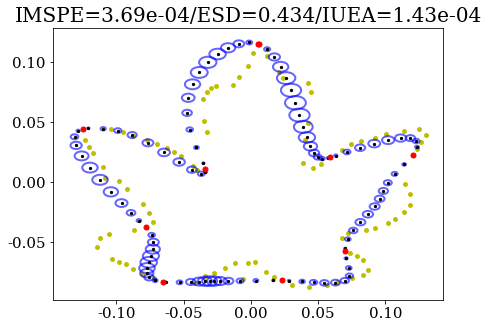

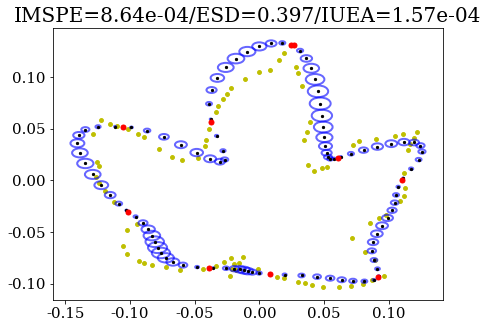

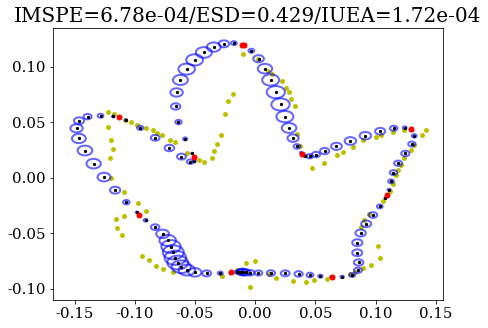

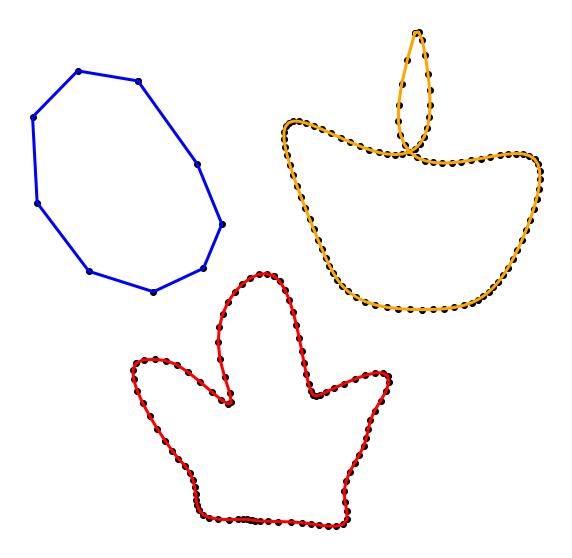

In [41]:
## Panel (a): no noise, n=10
# Original curves re-scaled to unit length and (0,0)-centered
exCURVES_obs = []
exCURVES_truth = []
curve_idx = [0,1,2]
N_obs = 10
pt_idx = np.round(np.linspace(0,n_o2-1,N_obs)).astype(int)
ctr = 0
for idx in curve_idx:
    beta = np.matmul(O,flav_data[0,idx,:,:])
    beta = np.hstack((beta,beta[:,0].reshape(-1,1)))
    beta_sc = cf.scale_curve(beta)[0]
    tmp = cf.calculatecentroid(beta_sc)
    beta_sc = beta_sc-np.transpose(np.tile(tmp,(n_o2+1,1)))
        
    exCURVES_obs.append(beta_sc[:,pt_idx])
    exCURVES_truth.append(beta_sc)
    
# Joint MOGP fit
MOGP1_fig9 = curveBatchMOGP(datapointList=exCURVES_obs, predList=100, truthpointList=exCURVES_truth, cen=True, scale=True, 
                   rot=True, nug=1e-3, showOutput=False, kernel='Matern32')
mu_x_List = MOGP1_fig9[2]
mu_y_List = MOGP1_fig9[4]

# Group-wise mean found by averaging the predictive mean curve for each leaf
gp_mean_x = np.mean(mu_x_List, axis=0).reshape(1,-1)
gp_mean_y = np.mean(mu_y_List, axis=0).reshape(1,-1)
gp_mean = np.vstack((gp_mean_x,gp_mean_y))

# Karcher mean just from observed sample points
beta_os = np.zeros((2,N_obs,len(curve_idx)))
for i in range(len(curve_idx)):
    beta_os[:,:,i] = exCURVES_obs[i]

beta_rs = np.zeros((2,101,len(curve_idx)))
for i in range(len(curve_idx)):
    beta_rs[:,0:100,i] = cf.resamplecurve(exCURVES_obs[i], N=100)
    beta_rs[:,100,i] = beta_rs[:,0,i]

beta_km = fdacurve(beta_os, N=N_obs, scale=True, mode='C')
beta_km.karcher_mean()
obs_kmean = beta_km.beta_mean

beta_rkm = fdacurve(beta_rs, N=101, scale=True, mode='C')
beta_rkm.karcher_mean()
obs_rkmean = beta_rkm.beta_mean

plt.figure(figsize=(10,10))
plt.plot(obs_kmean[0,:], obs_kmean[1,:], 'b', zorder=2, linewidth=3)
plt.scatter(obs_kmean[0,:], obs_kmean[1,:], c='k', zorder=1, alpha=1)
plt.plot(obs_rkmean[0,:]+0.30, obs_rkmean[1,:], color='orange', zorder=2, linewidth=3)
plt.scatter(obs_rkmean[0,:]+0.30, obs_rkmean[1,:], c='k', zorder=1, alpha=1)
plt.plot(gp_mean[0,:]+0.15, gp_mean[1,:]-0.20, 'r', zorder=2, linewidth=3)
plt.scatter(gp_mean[0,:]+0.15, gp_mean[1,:]-0.20, c='k', zorder=1, alpha=1)
plt.axis('off')

Computing Karcher Mean of 3 curves in SRVF space..
updating step: 1
updating step: 2
updating step: 3
updating step: 4
updating step: 5
updating step: 6


(-0.16273468395311316,
 0.163861630007386,
 -0.12213129612428247,
 0.15296847422129803)

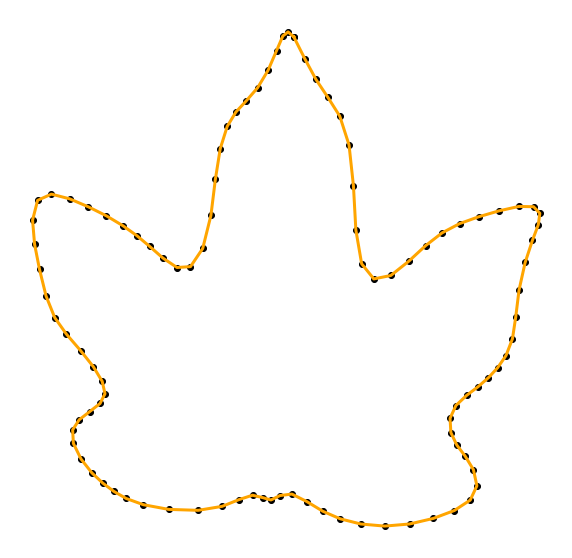

In [42]:
# True Karcher mean plot (using all 101 points)
beta_rs = np.zeros((2,101,len(curve_idx)))
for i in range(len(curve_idx)):
    beta_rs[:,:,i] = exCURVES_truth[i]

beta_rkm = fdacurve(beta_rs, N=101, scale=True, mode='C')
beta_rkm.karcher_mean()
true_kmean = beta_rkm.beta_mean

plt.figure(figsize=(10,10))
plt.plot(true_kmean[0,:], true_kmean[1,:], color='orange', zorder=2, linewidth=3)
plt.scatter(true_kmean[0,:], true_kmean[1,:], c='k', zorder=1, alpha=1)
plt.axis('off')

In [43]:
## Compute GW metric for each to true Karcher mean
xs = obs_kmean.T
xt = true_kmean.T
C1 = sp.spatial.distance.cdist(xs, xs) 
C2 = sp.spatial.distance.cdist(xt, xt)
C1 /= C1.max()
C2 /= C2.max()
p = ot.unif(xs.shape[0])
q = ot.unif(xt.shape[0])
gw0, log0 = ot.gromov.gromov_wasserstein(C1, C2, p, q, 'square_loss', verbose=False, log=True)

xs = obs_rkmean.T
xt = true_kmean.T
C1 = sp.spatial.distance.cdist(xs, xs) 
C2 = sp.spatial.distance.cdist(xt, xt)
C1 /= C1.max()
C2 /= C2.max()
p = ot.unif(xs.shape[0])
q = ot.unif(xt.shape[0])
gw1, log1 = ot.gromov.gromov_wasserstein(C1, C2, p, q, 'square_loss', verbose=False, log=True)

xs = gp_mean.T
xt = true_kmean.T
C1 = sp.spatial.distance.cdist(xs, xs) 
C2 = sp.spatial.distance.cdist(xt, xt)
C1 /= C1.max()
C2 /= C2.max()
p = ot.unif(xs.shape[0])
q = ot.unif(xt.shape[0])
gw2, log2 = ot.gromov.gromov_wasserstein(C1, C2, p, q, 'square_loss', verbose=False, log=True)

# Print distances
print('Observed sample KM GW: ' + str(log0['gw_dist']))
print('Interpolative re-sampling of bserved sample KM GW: ' + str(log1['gw_dist']))
print('Predictive GP mean GW: ' + str(log2['gw_dist']))

Observed sample KM GW: 0.03381990701766485
Interpolative re-sampling of bserved sample KM GW: 0.01904944996011725
Predictive GP mean GW: 0.004863501558697209


Computing Karcher Mean of 3 curves in SRVF space..
updating step: 1
updating step: 2
updating step: 3
updating step: 4
updating step: 5
updating step: 6
Computing Karcher Mean of 3 curves in SRVF space..
updating step: 1
updating step: 2
updating step: 3
updating step: 4
updating step: 5


(-0.15872746046846958,
 0.46181488752252897,
 -0.3168536991999422,
 0.15120585770531486)

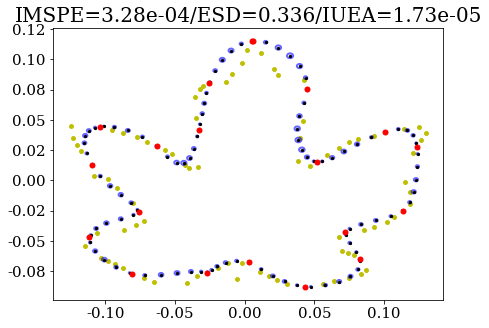

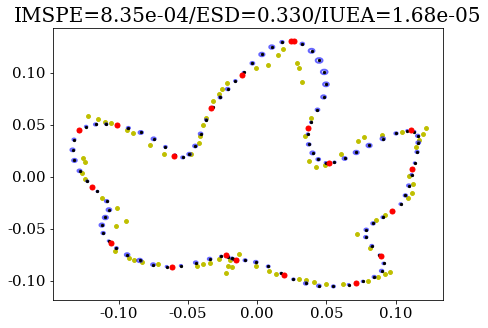

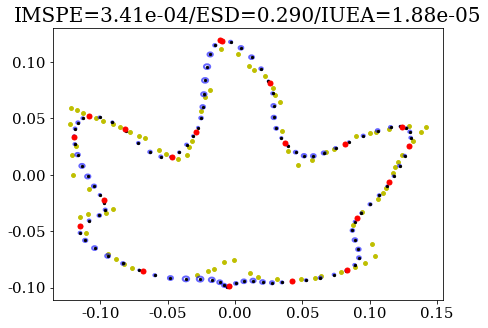

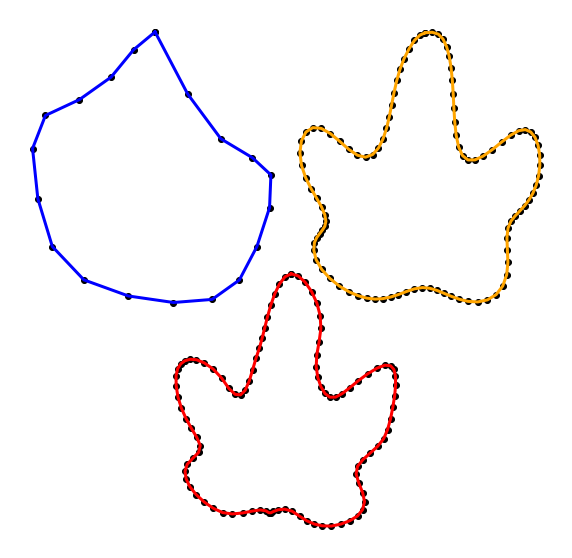

In [44]:
## Panel (b): no noise, n=20
# Original curves re-scaled to unit length and (0,0)-centered
exCURVES_obs = []
exCURVES_truth = []
curve_idx = [0,1,2]
N_obs = 20
pt_idx = np.round(np.linspace(0,n_o2-1,N_obs)).astype(int)
ctr = 0
for idx in curve_idx:
    beta = np.matmul(O,flav_data[0,idx,:,:])
    beta = np.hstack((beta,beta[:,0].reshape(-1,1)))
    beta_sc = cf.scale_curve(beta)[0]
    tmp = cf.calculatecentroid(beta_sc)
    beta_sc = beta_sc-np.transpose(np.tile(tmp,(n_o2+1,1)))
        
    exCURVES_obs.append(beta_sc[:,pt_idx])
    exCURVES_truth.append(beta_sc)
    
# Joint MOGP fit
MOGP2_fig9 = curveBatchMOGP(datapointList=exCURVES_obs, predList=100, truthpointList=exCURVES_truth, cen=True, scale=True, 
                   rot=True, nug=1e-3, showOutput=False, kernel='Matern32')
mu_x_List = MOGP2_fig9[2]
mu_y_List = MOGP2_fig9[4]

# Group-wise mean found by averaging the predictive mean curve for each leaf
gp_mean_x = np.mean(mu_x_List, axis=0).reshape(1,-1)
gp_mean_y = np.mean(mu_y_List, axis=0).reshape(1,-1)
gp_mean = np.vstack((gp_mean_x,gp_mean_y))

# Karcher mean just from observed sample points
beta_os = np.zeros((2,N_obs,len(curve_idx)))
for i in range(len(curve_idx)):
    beta_os[:,:,i] = exCURVES_obs[i]

beta_rs = np.zeros((2,101,len(curve_idx)))
for i in range(len(curve_idx)):
    beta_rs[:,0:100,i] = cf.resamplecurve(exCURVES_obs[i], N=100)
    beta_rs[:,100,i] = beta_rs[:,0,i]

beta_km = fdacurve(beta_os, N=N_obs, scale=True, mode='C')
beta_km.karcher_mean()
obs_kmean = beta_km.beta_mean

beta_rkm = fdacurve(beta_rs, N=101, scale=True, mode='C')
beta_rkm.karcher_mean()
obs_rkmean = beta_rkm.beta_mean

plt.figure(figsize=(10,10))
plt.plot(obs_kmean[0,:], obs_kmean[1,:], 'b', zorder=2, linewidth=3)
plt.scatter(obs_kmean[0,:], obs_kmean[1,:], c='k', zorder=1, alpha=1)
plt.plot(obs_rkmean[0,:]+0.30, obs_rkmean[1,:], color='orange', zorder=2, linewidth=3)
plt.scatter(obs_rkmean[0,:]+0.30, obs_rkmean[1,:], c='k', zorder=1, alpha=1)
plt.plot(gp_mean[0,:]+0.15, gp_mean[1,:]-0.20, 'r', zorder=2, linewidth=3)
plt.scatter(gp_mean[0,:]+0.15, gp_mean[1,:]-0.20, c='k', zorder=1, alpha=1)
plt.axis('off')

In [45]:
## Compute GW metric for each to true Karcher mean
xs = obs_kmean.T
xt = true_kmean.T
C1 = sp.spatial.distance.cdist(xs, xs) 
C2 = sp.spatial.distance.cdist(xt, xt)
C1 /= C1.max()
C2 /= C2.max()
p = ot.unif(xs.shape[0])
q = ot.unif(xt.shape[0])
gw0, log0 = ot.gromov.gromov_wasserstein(C1, C2, p, q, 'square_loss', verbose=False, log=True)

xs = obs_rkmean.T
xt = true_kmean.T
C1 = sp.spatial.distance.cdist(xs, xs) 
C2 = sp.spatial.distance.cdist(xt, xt)
C1 /= C1.max()
C2 /= C2.max()
p = ot.unif(xs.shape[0])
q = ot.unif(xt.shape[0])
gw1, log1 = ot.gromov.gromov_wasserstein(C1, C2, p, q, 'square_loss', verbose=False, log=True)

xs = gp_mean.T
xt = true_kmean.T
C1 = sp.spatial.distance.cdist(xs, xs) 
C2 = sp.spatial.distance.cdist(xt, xt)
C1 /= C1.max()
C2 /= C2.max()
p = ot.unif(xs.shape[0])
q = ot.unif(xt.shape[0])
gw2, log2 = ot.gromov.gromov_wasserstein(C1, C2, p, q, 'square_loss', verbose=False, log=True)

# Print distances
print('Observed sample KM GW: ' + str(log0['gw_dist']))
print('Interpolative re-sampling of bserved sample KM GW: ' + str(log1['gw_dist']))
print('Predictive GP mean GW: ' + str(log2['gw_dist']))

Observed sample KM GW: 0.023883424704015176
Interpolative re-sampling of bserved sample KM GW: 0.013502928148323472
Predictive GP mean GW: 0.01299736578309855


Computing Karcher Mean of 3 curves in SRVF space..
updating step: 1
updating step: 2
updating step: 3
updating step: 4
updating step: 5
Computing Karcher Mean of 3 curves in SRVF space..
updating step: 1
updating step: 2
updating step: 3
updating step: 4


(-0.17458986771758425,
 0.46450845501790117,
 -0.3158092862747373,
 0.15268726030389015)

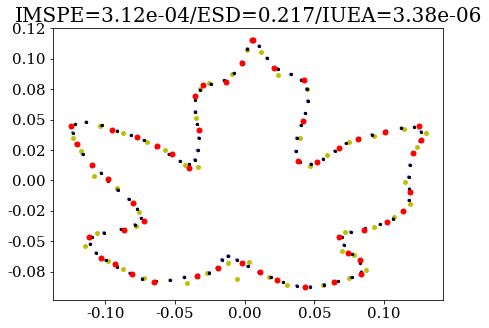

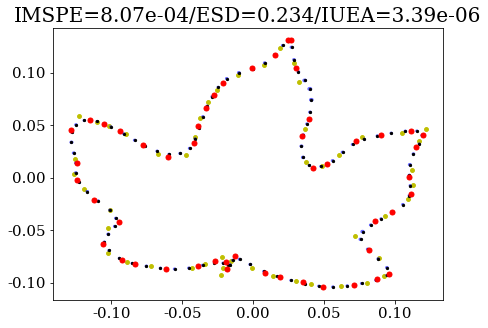

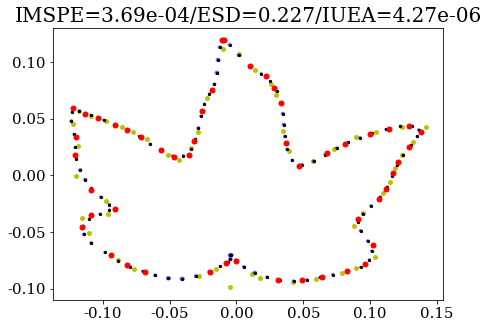

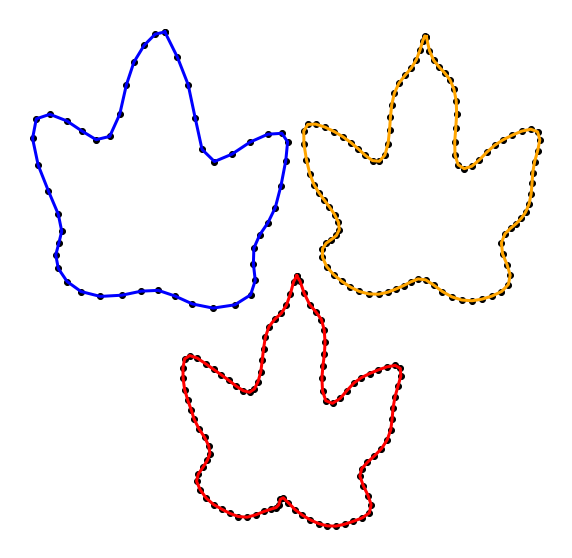

In [46]:
## Panel (c): no noise, n=50
# Original curves re-scaled to unit length and (0,0)-centered
exCURVES_obs = []
exCURVES_truth = []
curve_idx = [0,1,2]
N_obs = 50
pt_idx = np.round(np.linspace(0,n_o2-1,N_obs)).astype(int)
ctr = 0
for idx in curve_idx:
    beta = np.matmul(O,flav_data[0,idx,:,:])
    beta = np.hstack((beta,beta[:,0].reshape(-1,1)))
    beta_sc = cf.scale_curve(beta)[0]
    tmp = cf.calculatecentroid(beta_sc)
    beta_sc = beta_sc-np.transpose(np.tile(tmp,(n_o2+1,1)))
        
    exCURVES_obs.append(beta_sc[:,pt_idx])
    exCURVES_truth.append(beta_sc)
    
# Joint MOGP fit
MOGP3_fig9 = curveBatchMOGP(datapointList=exCURVES_obs, predList=100, truthpointList=exCURVES_truth, cen=True, scale=True, 
                   rot=True, nug=1e-3, showOutput=False, kernel='Matern32')
mu_x_List = MOGP3_fig9[2]
mu_y_List = MOGP3_fig9[4]

# Group-wise mean found by averaging the predictive mean curve for each leaf
gp_mean_x = np.mean(mu_x_List, axis=0).reshape(1,-1)
gp_mean_y = np.mean(mu_y_List, axis=0).reshape(1,-1)
gp_mean = np.vstack((gp_mean_x,gp_mean_y))

# Karcher mean just from observed sample points
beta_os = np.zeros((2,N_obs,len(curve_idx)))
for i in range(len(curve_idx)):
    beta_os[:,:,i] = exCURVES_obs[i]

beta_rs = np.zeros((2,101,len(curve_idx)))
for i in range(len(curve_idx)):
    beta_rs[:,0:100,i] = cf.resamplecurve(exCURVES_obs[i], N=100)
    beta_rs[:,100,i] = beta_rs[:,0,i]

beta_km = fdacurve(beta_os, N=N_obs, scale=True, mode='C')
beta_km.karcher_mean()
obs_kmean = beta_km.beta_mean

beta_rkm = fdacurve(beta_rs, N=101, scale=True, mode='C')
beta_rkm.karcher_mean()
obs_rkmean = beta_rkm.beta_mean

plt.figure(figsize=(10,10))
plt.plot(obs_kmean[0,:], obs_kmean[1,:], 'b', zorder=2, linewidth=3)
plt.scatter(obs_kmean[0,:], obs_kmean[1,:], c='k', zorder=1, alpha=1)
plt.plot(obs_rkmean[0,:]+0.30, obs_rkmean[1,:], color='orange', zorder=2, linewidth=3)
plt.scatter(obs_rkmean[0,:]+0.30, obs_rkmean[1,:], c='k', zorder=1, alpha=1)
plt.plot(gp_mean[0,:]+0.15, gp_mean[1,:]-0.20, 'r', zorder=2, linewidth=3)
plt.scatter(gp_mean[0,:]+0.15, gp_mean[1,:]-0.20, c='k', zorder=1, alpha=1)
plt.axis('off')

In [47]:
## Compute GW metric for each to true Karcher mean
xs = obs_kmean.T
xt = true_kmean.T
C1 = sp.spatial.distance.cdist(xs, xs) 
C2 = sp.spatial.distance.cdist(xt, xt)
C1 /= C1.max()
C2 /= C2.max()
p = ot.unif(xs.shape[0])
q = ot.unif(xt.shape[0])
gw0, log0 = ot.gromov.gromov_wasserstein(C1, C2, p, q, 'square_loss', verbose=False, log=True)

xs = obs_rkmean.T
xt = true_kmean.T
C1 = sp.spatial.distance.cdist(xs, xs) 
C2 = sp.spatial.distance.cdist(xt, xt)
C1 /= C1.max()
C2 /= C2.max()
p = ot.unif(xs.shape[0])
q = ot.unif(xt.shape[0])
gw1, log1 = ot.gromov.gromov_wasserstein(C1, C2, p, q, 'square_loss', verbose=False, log=True)

xs = gp_mean.T
xt = true_kmean.T
C1 = sp.spatial.distance.cdist(xs, xs) 
C2 = sp.spatial.distance.cdist(xt, xt)
C1 /= C1.max()
C2 /= C2.max()
p = ot.unif(xs.shape[0])
q = ot.unif(xt.shape[0])
gw2, log2 = ot.gromov.gromov_wasserstein(C1, C2, p, q, 'square_loss', verbose=False, log=True)

# Print distances
print('Observed sample KM GW: ' + str(log0['gw_dist']))
print('Interpolative re-sampling of bserved sample KM GW: ' + str(log1['gw_dist']))
print('Predictive GP mean GW: ' + str(log2['gw_dist']))

Observed sample KM GW: 0.014066035770541982
Interpolative re-sampling of bserved sample KM GW: 0.009316763244045371
Predictive GP mean GW: 0.0020280222365263094


Computing Karcher Mean of 3 curves in SRVF space..
updating step: 1
updating step: 2
updating step: 3
updating step: 4
updating step: 5
updating step: 6
Computing Karcher Mean of 3 curves in SRVF space..
updating step: 1
updating step: 2
updating step: 3
updating step: 4
updating step: 5
updating step: 6
updating step: 7


(-0.17863968815889947,
 0.5230670711058856,
 -0.315706147697227,
 0.1555032336487535)

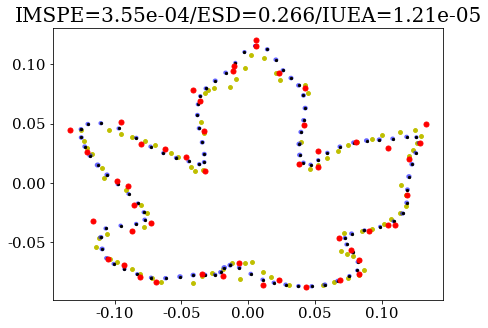

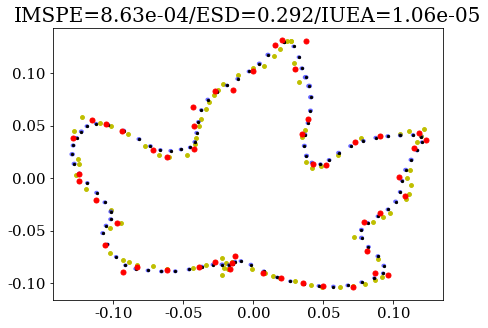

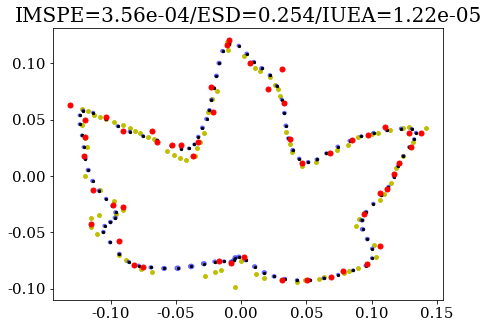

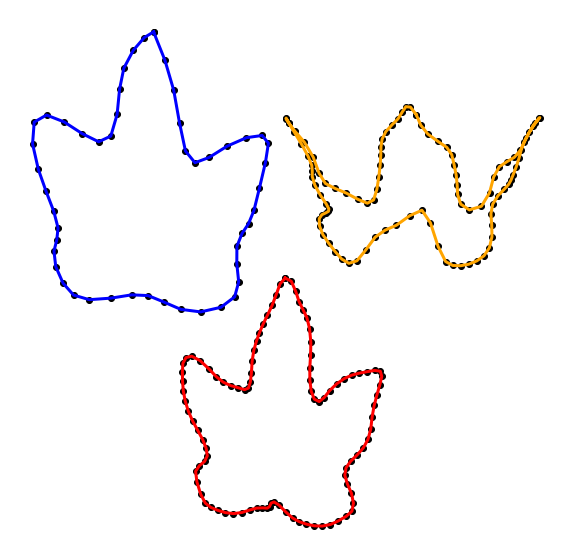

In [48]:
## Panel (d): Gaussian noise, n=50
# Original curves re-scaled to unit length and (0,0)-centered
exCURVES_obs = []
exCURVES_truth = []
curve_idx = [0,1,2]
N_obs = 50
pt_idx = np.round(np.linspace(0,n_o2-1,N_obs)).astype(int)

np.random.seed(49)

ctr = 0
for idx in curve_idx:
    beta = np.matmul(O,flav_data[0,idx,:,:])
    beta = np.hstack((beta,beta[:,0].reshape(-1,1)))
    beta_sc = cf.scale_curve(beta)[0]
    tmp = cf.calculatecentroid(beta_sc)
    beta_sc = beta_sc-np.transpose(np.tile(tmp,(n_o2+1,1)))
    
    exCURVES_truth.append(beta_sc)
    
    # Add Bernoulli noise along each coordinate to true curve to obtain observed
    tmp2 = copy.deepcopy(beta_sc)
    for t in range(0,n_o2):
        noise_ind = np.random.binomial(n=1, p=0.5, size=2)
        if noise_ind[0]==1:
            tmp2[0,t] = tmp2[0,t] + np.random.normal(loc=0, scale=0.007, size=1)
        if noise_ind[1]==1:
            tmp2[1,t] = tmp2[1,t] + np.random.normal(loc=0, scale=0.007, size=1)     
    tmp2[:,-1] = tmp2[:,0]
    
    tmp_obs = tmp2[:,pt_idx]      
    exCURVES_obs.append(tmp_obs)

# Joint MOGP fit
MOGP4_fig9 = curveBatchMOGP(datapointList=exCURVES_obs, predList=100, truthpointList=exCURVES_truth, cen=True, scale=True, 
                   rot=True, nug=1e-3, showOutput=False, kernel='Matern32')
mu_x_List = MOGP4_fig9[2]
mu_y_List = MOGP4_fig9[4]

# Group-wise mean found by averaging the predictive mean curve for each leaf
gp_mean_x = np.mean(mu_x_List, axis=0).reshape(1,-1)
gp_mean_y = np.mean(mu_y_List, axis=0).reshape(1,-1)
gp_mean = np.vstack((gp_mean_x,gp_mean_y))

# Karcher mean just from observed sample points
beta_os = np.zeros((2,N_obs,len(curve_idx)))
for i in range(len(curve_idx)):
    beta_os[:,:,i] = exCURVES_obs[i]

beta_rs = np.zeros((2,101,len(curve_idx)))
for i in range(len(curve_idx)):
    beta_rs[:,0:100,i] = cf.resamplecurve(exCURVES_obs[i], N=100)
    beta_rs[:,100,i] = beta_rs[:,0,i]

beta_km = fdacurve(beta_os, N=N_obs, scale=True, mode='C')
beta_km.karcher_mean()
obs_kmean = beta_km.beta_mean

beta_rkm = fdacurve(beta_rs, N=101, scale=True, mode='C')
beta_rkm.karcher_mean()
obs_rkmean = beta_rkm.beta_mean

plt.figure(figsize=(10,10))
plt.plot(obs_kmean[0,:], obs_kmean[1,:], 'b', zorder=2, linewidth=3)
plt.scatter(obs_kmean[0,:], obs_kmean[1,:], c='k', zorder=1, alpha=1)
plt.plot(obs_rkmean[0,:]+0.33, obs_rkmean[1,:], color='orange', zorder=2, linewidth=3)
plt.scatter(obs_rkmean[0,:]+0.33, obs_rkmean[1,:], c='k', zorder=1, alpha=1)
plt.plot(gp_mean[0,:]+0.165, gp_mean[1,:]-0.20, 'r', zorder=2, linewidth=3)
plt.scatter(gp_mean[0,:]+0.165, gp_mean[1,:]-0.20, c='k', zorder=1, alpha=1)
plt.axis('off')

In [49]:
## Compute GW metric for each to true Karcher mean
xs = obs_kmean.T
xt = true_kmean.T
C1 = sp.spatial.distance.cdist(xs, xs) 
C2 = sp.spatial.distance.cdist(xt, xt)
C1 /= C1.max()
C2 /= C2.max()
p = ot.unif(xs.shape[0])
q = ot.unif(xt.shape[0])
gw0, log0 = ot.gromov.gromov_wasserstein(C1, C2, p, q, 'square_loss', verbose=False, log=True)

xs = obs_rkmean.T
xt = true_kmean.T
C1 = sp.spatial.distance.cdist(xs, xs) 
C2 = sp.spatial.distance.cdist(xt, xt)
C1 /= C1.max()
C2 /= C2.max()
p = ot.unif(xs.shape[0])
q = ot.unif(xt.shape[0])
gw1, log1 = ot.gromov.gromov_wasserstein(C1, C2, p, q, 'square_loss', verbose=False, log=True)

xs = gp_mean.T
xt = true_kmean.T
C1 = sp.spatial.distance.cdist(xs, xs) 
C2 = sp.spatial.distance.cdist(xt, xt)
C1 /= C1.max()
C2 /= C2.max()
p = ot.unif(xs.shape[0])
q = ot.unif(xt.shape[0])
gw2, log2 = ot.gromov.gromov_wasserstein(C1, C2, p, q, 'square_loss', verbose=False, log=True)

# Print distances
print('Observed sample KM GW: ' + str(log0['gw_dist']))
print('Interpolative re-sampling of bserved sample KM GW: ' + str(log1['gw_dist']))
print('Predictive GP mean GW: ' + str(log2['gw_dist']))

Observed sample KM GW: 0.01426314948722296
Interpolative re-sampling of bserved sample KM GW: 0.026193050047904433
Predictive GP mean GW: 0.002367434987646983


### More robust elastic shape registration using the multiple-output GP model (Figure 15)

In [50]:
# Save curves within specified shape class to a single array, and compute SRVF
# shape_idx - index of shape class (see MPEG_key.txt for index labels)
shape_idx = 49
m = 20
n = n_o1+1  # number of sample points for each curve when first point = last point (since closed)
beta = np.zeros((d1,n,m1))
beta_sc = np.zeros((d1,n,m1))

# Apply rotation matrix
theta = np.radians(30)
O = np.array(((np.cos(theta),-np.sin(theta)), (np.sin(theta),np.cos(theta))))

# Original curves re-scaled to unit length and (0,0)-centered
for i in range(0,m1):
    beta[:,0:n_o1,i] = np.matmul(O,mpeg_data[shape_idx,i])
    beta[:,n_o1,i] = beta[:,0,i]
    beta_sc[:,:,i] = cf.scale_curve(beta[:,:,i])[0]
    tmp = cf.calculatecentroid(beta_sc[:,:,i])
    beta_sc[:,:,i] = beta_sc[:,:,i]-np.transpose(np.tile(tmp,(n,1)))

Text(0.5, 1.0, 'Before GP fit: GW=1.85e-02')

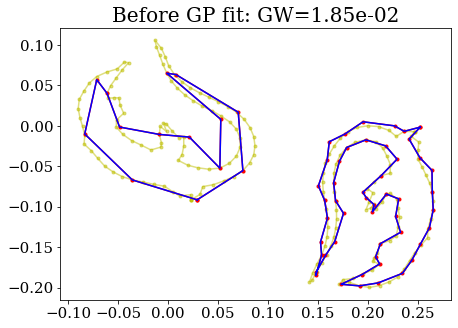

In [51]:
# Prepare data (list format)
exCURVES_obs = []
exCURVES_truth = []

# Curves
# Vary number of points
curve_idx = [0,1]
np.random.seed(51)

for i in range(0,2):
    N_obs = 15+35*i
    samp_idx = np.round(np.linspace(0,n_o1,N_obs)).astype(int)
    
    tmp = copy.deepcopy(beta_sc[:,:,curve_idx[i]])
    for t in range(0,n_o1):
        noise_ind = np.random.binomial(n=1, p=0.5, size=2)
        if noise_ind[0]==1:
            tmp[0,t] = tmp[0,t] + np.random.normal(loc=0, scale=0.005, size=1)
        if noise_ind[1]==1:
            tmp[1,t] = tmp[1,t] + np.random.normal(loc=0, scale=0.005, size=1)     
    tmp[:,-1] = tmp[:,0]
    
    exCURVES_obs.append(tmp[:,samp_idx])
    exCURVES_truth.append(beta_sc[:,:,curve_idx[i]])
    
    theta = np.radians(135)
    O = np.array(((np.cos(theta),-np.sin(theta)), (np.sin(theta),np.cos(theta))))
    if i==1:
        exCURVES_obs[i] = O@exCURVES_obs[i]
        exCURVES_truth[i] = O@exCURVES_truth[i]

# Gromov-Wasserstein
xs = exCURVES_obs[0].T
xt = exCURVES_obs[1].T
C1 = sp.spatial.distance.cdist(xs, xs) 
C2 = sp.spatial.distance.cdist(xt, xt)
C1 /= C1.max()
C2 /= C2.max()
p = ot.unif(exCURVES_obs[0].shape[1])
q = ot.unif(exCURVES_obs[1].shape[1])
gw0, log0 = ot.gromov.gromov_wasserstein(C1, C2, p, q, 'square_loss', verbose=False, log=True)
gw = log0['gw_dist']

# Plot original curves
x_offset = 0.2
y_offset = 0.1
plt.rcParams["font.family"] = "serif"
fig, ax = plt.subplots(figsize=(7,5))
for i in range(0,len(exCURVES_obs)):
    plt.plot(exCURVES_truth[i][0,:]+x_offset*i, exCURVES_truth[i][1,:]-y_offset*i, c='y', marker='.', alpha=0.5)
    plt.plot(exCURVES_obs[i][0,:]+x_offset*i, exCURVES_obs[i][1,:]-y_offset*i, c='r', marker='.')
    plt.plot(exCURVES_obs[i][0,:]+x_offset*i, exCURVES_obs[i][1,:]-y_offset*i, c='b')
plt.xticks(size=15)
plt.yticks(size=15)
plt.title(f'Before GP fit: GW={gw:.2e}', size=20)

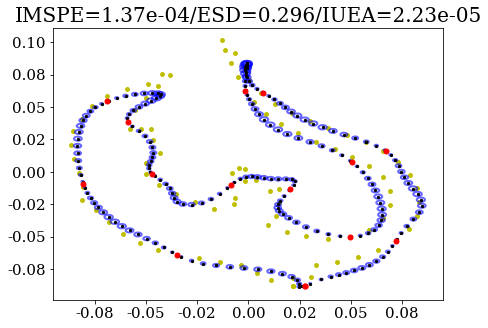

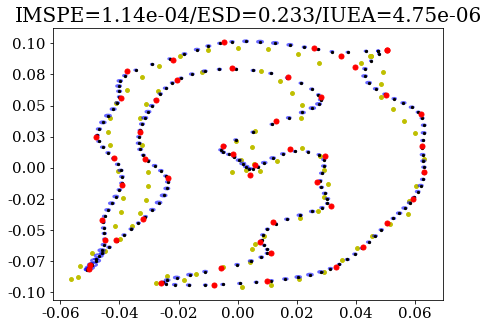

In [52]:
# MOGP fit
MOGP_fig10 = curveBatchMOGP(datapointList=exCURVES_obs, predList=200, truthpointList=exCURVES_truth, kernel='Matern32', 
                            cen=True, scale=True, rot=False, showOutput=False)
mu_x_List = MOGP_fig10[2]
mu_y_List = MOGP_fig10[4]

Text(0.5, 1.0, 'After GP fit: GW=8.71e-03')

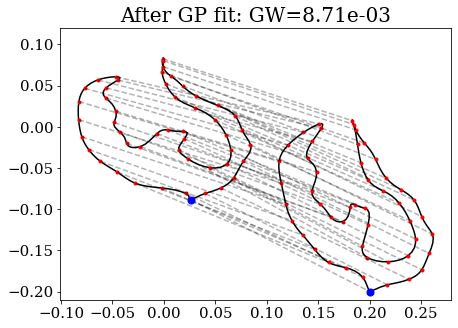

In [53]:
# Elastic registration of curves based on estimated means from MOGP fit
beta_rs = np.zeros((2,200,len(mu_x_List)))     
for m in range(0,len(mu_x_List)):
    beta_rs[0,:,m] = mu_x_List[m]
    beta_rs[1,:,m] = mu_y_List[m]
    
er_mean = fdacurve_v2(beta_rs, mode='C', N=200, scale=False)
q_rs = er_mean.q

q2best, Rbest, gamIbest, ctrbest = find_rotation_and_seed_unique_warpv2(q_rs[:,:,0], q_rs[:,:,1], closed=1, 
                                                                        rotation=True, method='DP')
beta2best = cf.q_to_curve(q2best)
beta_mean = np.dstack((beta_rs[:,:,0],beta2best))

# Gromov-Wasserstein
xs = beta_mean[:,:,0].T
xt = beta_mean[:,:,1].T
C1 = sp.spatial.distance.cdist(xs, xs) 
C2 = sp.spatial.distance.cdist(xt, xt)
C1 /= C1.max()
C2 /= C2.max()
p = ot.unif(beta_mean[:,:,0].shape[1])
q = ot.unif(beta_mean[:,:,1].shape[1])
gw0, log0 = ot.gromov.gromov_wasserstein(C1, C2, p, q, 'square_loss', verbose=False, log=True)
gw = log0['gw_dist']

# Plot of registered curves based on estimated means
plt.rcParams["font.family"] = "serif"
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(beta_mean[0,:,0], beta_mean[1,:,0], c='k')
ax.plot(beta_mean[0,:,1]+x_offset, beta_mean[1,:,1]-y_offset-0.10, c='k')
for i in range(0,200):
    if i%4==0:
        ax.plot(beta_mean[0,i,0], beta_mean[1,i,0], c='r', marker='.')
        ax.plot(beta_mean[0,i,1]+x_offset, beta_mean[1,i,1]-y_offset-0.10, c='r', marker='.')
        ax.plot([beta_mean[0,i,0],beta_mean[0,i,1]+x_offset], [beta_mean[1,i,0],beta_mean[1,i,1]-y_offset-0.10], c='k', linestyle='dashed', alpha=0.3)      
ax.scatter(beta_mean[0,0,0], beta_mean[1,0,0], c='b', marker='.', s=200, zorder=5)
ax.scatter(beta_mean[0,0,1]+x_offset, beta_mean[1,0,1]-y_offset-0.10, c='b', marker='.', s=200, zorder=5)
ax.set_ylim((-0.21,0.12))
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_title(f'After GP fit: GW={gw:.2e}', size=20)

### Simultaneous landmarking using multiple-output GP model (Figure 5)

In [84]:
# Save curves within specified shape class to a single array, and compute SRVF
# shape_idx - index of shape class
shape_idx = 0
n = n_o2+1  # number of sample points for each curve when first point = last point (since closed)
beta = np.zeros((d2,n,m2))
beta_sc = np.zeros((d2,n,m2))

# Apply rotation matrix (to test coregionalization model specifications)
theta = np.radians(180)
O = np.array(((np.cos(theta),-np.sin(theta)), (np.sin(theta),np.cos(theta))))

# Original curves re-scaled to unit length and (0,0)-centered
for i in range(0,m2):
    beta[:,0:n_o2,i] = np.matmul(O,flav_data[shape_idx,i,:,:])
    beta[:,n_o2,i] = beta[:,0,i]
    beta_sc[:,:,i] = cf.scale_curve(beta[:,:,i])[0]
    tmp = cf.calculatecentroid(beta_sc[:,:,i])
    beta_sc[:,:,i] = beta_sc[:,:,i]-np.transpose(np.tile(tmp,(n,1)))

In [85]:
# Prepare data (list format)
exCURVES_truth = []

# Curve
for i in range(0,3):
    exCURVES_truth.append(beta_sc[:,:,i])
    
# Number of landmarks desired
min_lmk = 3
max_lmk = 20

In [107]:
## Naive approach - randomly subset N_lmk unique points from exCURVES_truth
n_true = exCURVES_truth[0].shape[1]
n_rnd = 100  # in the manuscript, we use 1000; we modify this to 100 to make this quicker to run
lmk_idx = []
exCURVES_obs = []
IMSPE = []
IUEA = []
idx_error = []

# Random subset
import random
for n_lmk in range(min_lmk,max_lmk+1):
    fix_lmk = []
    fix_obs = []
    fix_IMSPE = []
    fix_IUEA = []
    fix_error = []
    
    for i in range(n_rnd):
        tmp = np.sort(random.sample(range(n_true-1),n_lmk))
        tmp = np.hstack((tmp,tmp[0]))
        fix_lmk.append(tmp)

        tmp_obs = []
        for j in range(len(exCURVES_truth)):
            tmp_obs.append(exCURVES_truth[j][:,tmp])
        fix_obs.append(tmp_obs)

        # Joint MOGP fit
        try:
            MOGP_fit = curveBatchMOGP(datapointList=fix_obs[i], predList=100, truthpointList=exCURVES_truth, cen=True, 
                                      scale=True, rot=True, nug=1e-3, showOutput=False, showPlot=False, kernel='Matern32', 
                                      showElastic=False)

            # Append performance metrics
            fix_IMSPE.append(MOGP_fit[8])
            fix_IUEA.append(MOGP_fit[10])

        except:
            fix_IMSPE.append([float("inf") for i in range(3)])
            fix_IUEA.append([float("inf") for i in range(3)])
            fix_error.append(i)
            pass

        # Print index
        if i%25==0:
            print([n_lmk,i])
            
    lmk_idx.append(fix_lmk)
    exCURVES_obs.append(fix_obs)
    IMSPE.append(fix_IMSPE)
    IUEA.append(fix_IUEA)
    idx_error.append(fix_error)

[3, 0]
[3, 25]
[3, 50]
[3, 75]
[4, 0]
[4, 25]
[4, 50]
[4, 75]
[5, 0]
[5, 25]
[5, 50]
[5, 75]
[6, 0]
[6, 25]
[6, 50]
[6, 75]
[7, 0]
[7, 25]
[7, 50]
[7, 75]
[8, 0]
[8, 25]
[8, 50]
[8, 75]
[9, 0]
[9, 25]
[9, 50]
[9, 75]
[10, 0]
[10, 25]
[10, 50]
[10, 75]
[11, 0]
[11, 25]
[11, 50]
[11, 75]
[12, 0]
[12, 25]
[12, 50]
[12, 75]
[13, 0]
[13, 25]
[13, 50]
[13, 75]
[14, 0]
[14, 25]
[14, 50]
[14, 75]
[15, 0]
[15, 25]
[15, 50]
[15, 75]
[16, 0]
[16, 25]
[16, 50]
[16, 75]
[17, 0]
[17, 25]
[17, 50]
[17, 75]
[18, 0]
[18, 25]
[18, 50]
[18, 75]
[19, 0]
[19, 25]
[19, 50]
[19, 75]
[20, 0]
[20, 25]
[20, 50]
[20, 75]


In [109]:
# Save results from above simulation via pickle
import pickle
lmk_sim = [lmk_idx, exCURVES_obs, IMSPE, IUEA, idx_error]
with open('lmk_sim.pkl', 'wb') as f:
    pickle.dump(lmk_sim, f)   

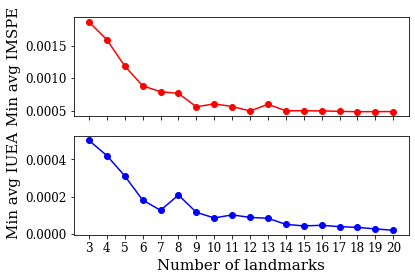

In [110]:
# Identify minimum IMSPE and IUEA values and their associated landmark configurations
min_IMSPE = []
min_IMSPE_idx = []
min_IUEA = []
min_IUEA_idx = []

idx = 0
for i in range(min_lmk,max_lmk+1):
    # Average across curves
    avg_IMSPE = np.mean(IMSPE[idx], axis=1)
    avg_IUEA = np.mean(IUEA[idx], axis=1)
    
    # Report minimizers
    idx1 = np.argsort(avg_IMSPE)
    idx2 = np.argsort(avg_IUEA)
    
    min_IMSPE_idx.append(idx1[0])
    min_IUEA_idx.append(idx2[0])
    
    # Report minimizing IMSPE and IUEA values
    min_IMSPE.append(avg_IMSPE[idx1[0]])
    min_IUEA.append(avg_IUEA[idx2[0]])
    
    idx += 1
    
# Plot
import matplotlib.pylab as pylab
plt.rcParams["font.family"] = "serif"
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.plot(range(min_lmk,max_lmk+1), min_IMSPE, c='r')
ax1.scatter(range(min_lmk,max_lmk+1), min_IMSPE, c='r')
ax1.set_xticks(np.arange(min_lmk, max_lmk+1, step=1))
ax2.plot(range(min_lmk,max_lmk+1), min_IUEA, c='b')
ax2.scatter(range(min_lmk,max_lmk+1), min_IUEA, c='b')
ax2.set_xticks(np.arange(min_lmk, max_lmk+1, step=1))
plt.xlabel('Number of landmarks', fontsize=15)
ax1.set_ylabel('Min avg IMSPE', fontsize=15)
ax2.set_ylabel('Min avg IUEA', fontsize=15)
params = {'xtick.labelsize': 'large',
          'ytick.labelsize': 'large'}
pylab.rcParams.update(params)

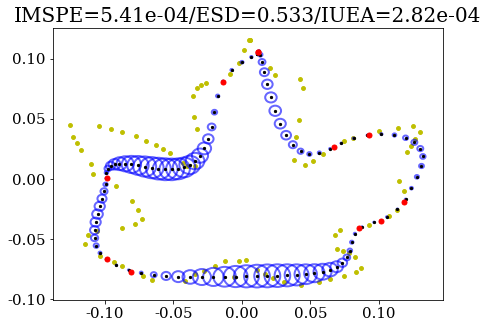

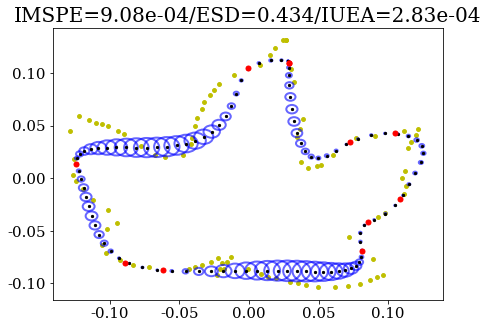

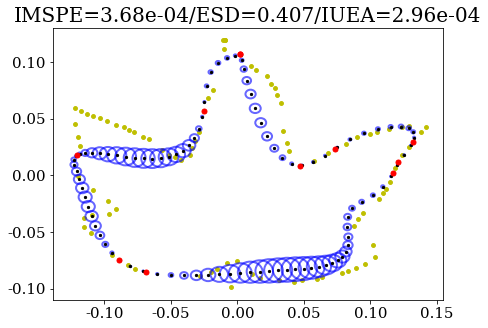

In [111]:
# Plot MOGP fit for minimizing landmark configuration at IMSPE elbow
MOGP_fig11 = curveBatchMOGP(datapointList=exCURVES_obs[7][min_IMSPE_idx[7]], predList=100, truthpointList=exCURVES_truth, 
                            cen=True, scale=True, rot=True, nug=1e-3, showOutput=False, showPlot=True, kernel='Matern32', 
                            showElastic=True)

### Comparison of sequential landmarking using single-output and multiple-output GP models (Figure 6)

In [56]:
# Save curves within specified shape class to a single array, and compute SRVF
# shape_idx - index of shape class
shape_idx = 0
n = n_o2+1  # number of sample points for each curve when first point = last point (since closed)
beta = np.zeros((d2,n,m2))
beta_sc = np.zeros((d2,n,m2))

# Apply rotation matrix (to test coregionalization model specifications)
theta = np.radians(180)
O = np.array(((np.cos(theta),-np.sin(theta)), (np.sin(theta),np.cos(theta))))

# Original curves re-scaled to unit length and (0,0)-centered
for i in range(0,m2):
    beta[:,0:n_o2,i] = np.matmul(O,flav_data[shape_idx,i,:,:])
    beta[:,n_o2,i] = beta[:,0,i]
    beta_sc[:,:,i] = cf.scale_curve(beta[:,:,i])[0]
    tmp = cf.calculatecentroid(beta_sc[:,:,i])
    beta_sc[:,:,i] = beta_sc[:,:,i]-np.transpose(np.tile(tmp,(n,1)))

In [57]:
# Prepare data (list format)
exCURVES_truth = []
exCURVES_obs = []

# Curve
N_obs = 7
random.seed(128)
for i in range(0,3):
    # Curve indices to extract for observed curves and parameter values to predict curves at
    curve_idx = np.hstack( (0, np.sort(random.sample(list(range(1,n_o2)), N_obs-2)), n_o2) )
    exCURVES_truth.append(beta_sc[:,:,i])
    exCURVES_obs.append(beta_sc[:,curve_idx,i])

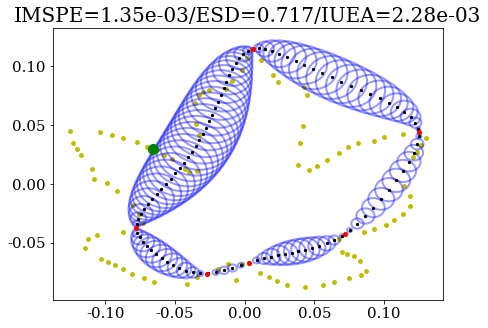

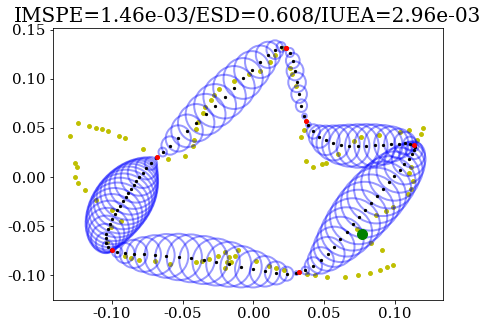

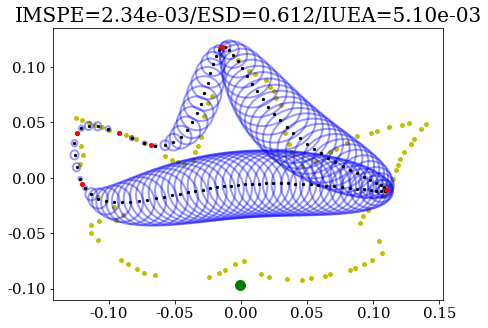

In [58]:
# SOGP landmarking
lmk_sogp_fig12 = []
for i in range(0,3):
    tmp = curveSOGP_LM(datapoint=exCURVES_obs[i], predpoint=100, truthpoint=exCURVES_truth[i], cen=True, scale=True, 
                       showOutput=False)
    lmk_sogp_fig12.append(tmp)

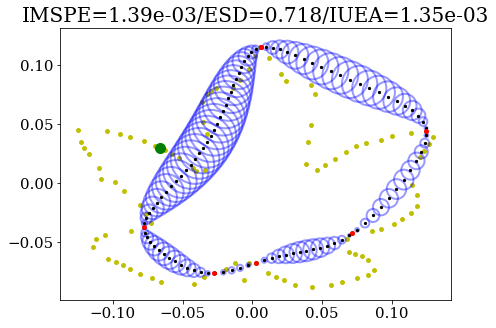

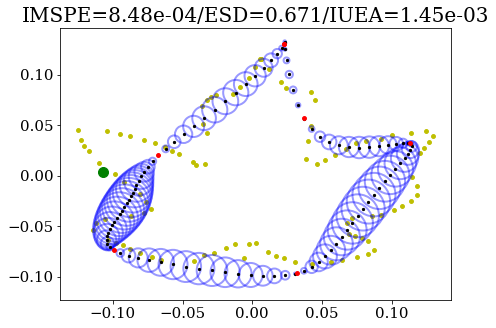

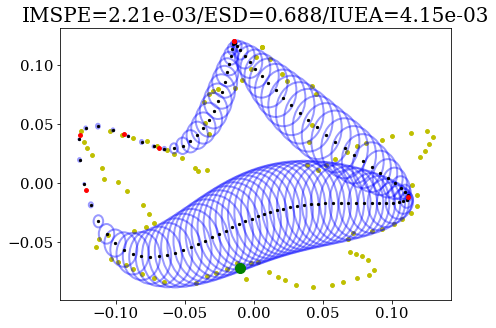

In [59]:
# MOGP landmarking for single curve
lmk_mogp11_fig12 = curveBatchMOGP_LM(datapointList=[exCURVES_obs[0]], predList=100, truthpointList=[exCURVES_truth[0]], 
                                     cen=True, scale=True, rot=False, nug=1e-3, showOutput=False)
lmk_mogp12_fig12 = curveBatchMOGP_LM(datapointList=[exCURVES_obs[1]], predList=100, truthpointList=[exCURVES_truth[0]], 
                                     cen=True, scale=True, rot=False, nug=1e-3, showOutput=False)
lmk_mogp13_fig12 = curveBatchMOGP_LM(datapointList=[exCURVES_obs[2]], predList=100, truthpointList=[exCURVES_truth[0]], 
                                     cen=True, scale=True, rot=False, nug=1e-3, showOutput=False)

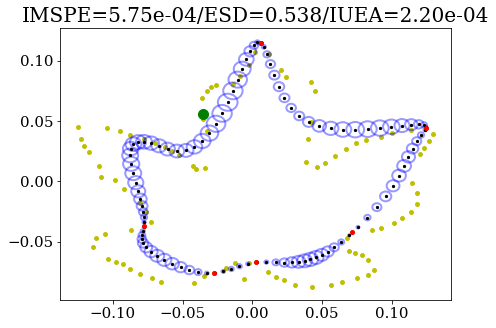

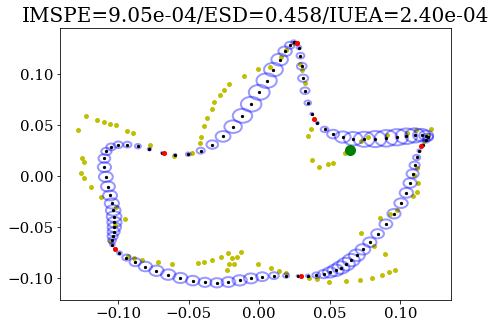

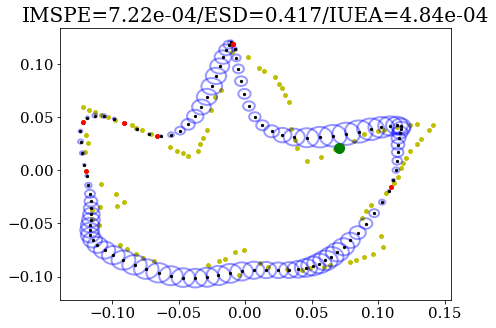

In [60]:
# MOGP landmarking for multiple curves
lmk_mogp2_fig12 = curveBatchMOGP_LM(datapointList=exCURVES_obs, predList=100, truthpointList=exCURVES_truth, cen=True, 
                                    scale=True, rot=True, nug=1e-3, showOutput=False) 

### Multiple-output GP fitting for multiple sub-populations (Figure 8)

In [61]:
# Save curves within specified shape class to a single array, and compute SRVF
shape_idx_list = [0,1]
n = n_o2+1  # number of sample points for each curve when first point = last point (since closed)

# Apply rotation matrix (to test coregionalization model specifications)
theta = np.radians(0)  # change to 30 for horizontal bone, 315 for vertical bone
O = np.array(((np.cos(theta),-np.sin(theta)), (np.sin(theta),np.cos(theta))))

# Original curves re-scaled to unit length and (0,0)-centered
exCURVES_obs = []
exCURVES_truth = []
curve_idx = [0,2,4,6,8,10,12,14] #16 samples per class
N_obs = 10
pt_idx = np.round(np.linspace(0,n_o2-1,N_obs)).astype(int)
ctr = 0
for shape_idx in shape_idx_list:
    for idx in range(16):
        beta = np.matmul(O,flav_data[shape_idx,idx,:,:])
        beta = np.hstack((beta,beta[:,0].reshape(-1,1)))
        beta_sc = cf.scale_curve(beta)[0]
        tmp = cf.calculatecentroid(beta_sc)
        beta_sc = beta_sc-np.transpose(np.tile(tmp,(n_o2+1,1)))
        
        exCURVES_obs.append(beta_sc[:,pt_idx])
        exCURVES_truth.append(beta_sc)

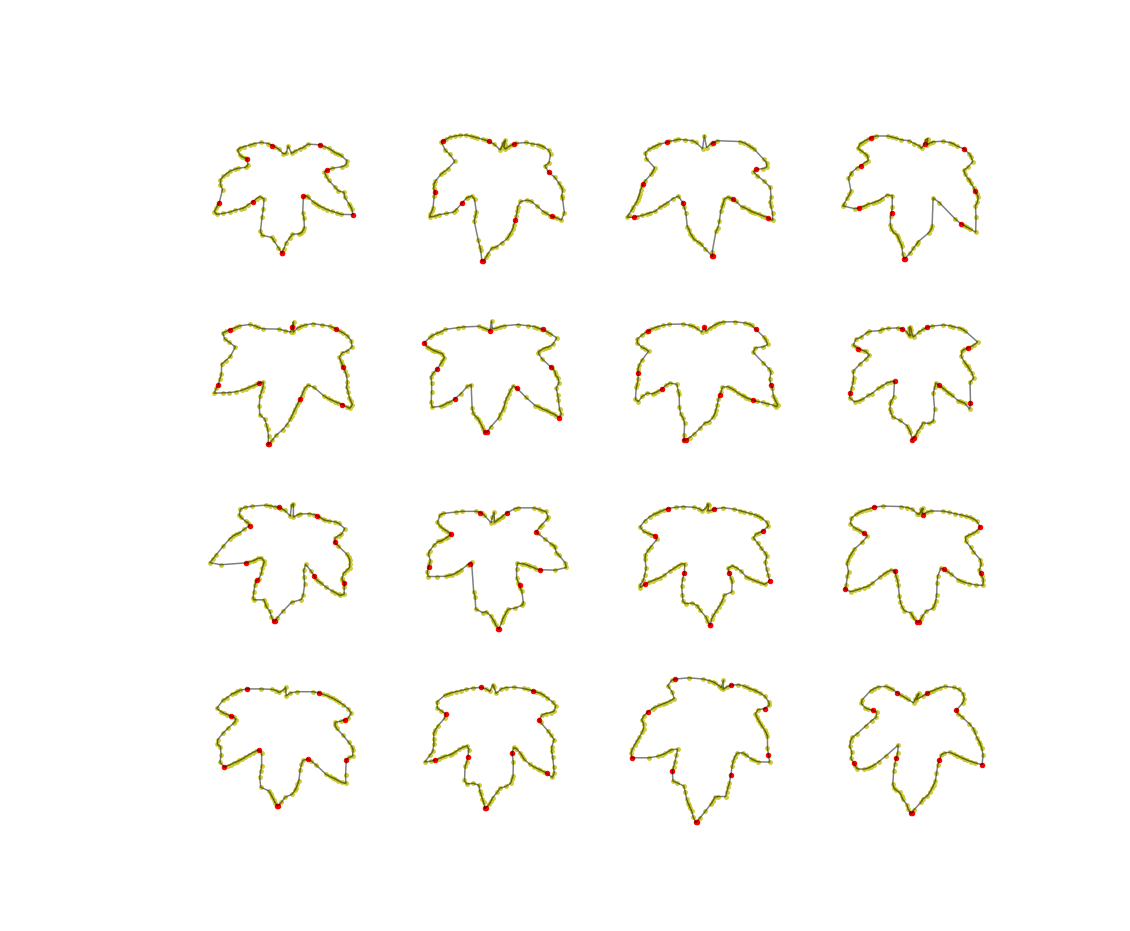

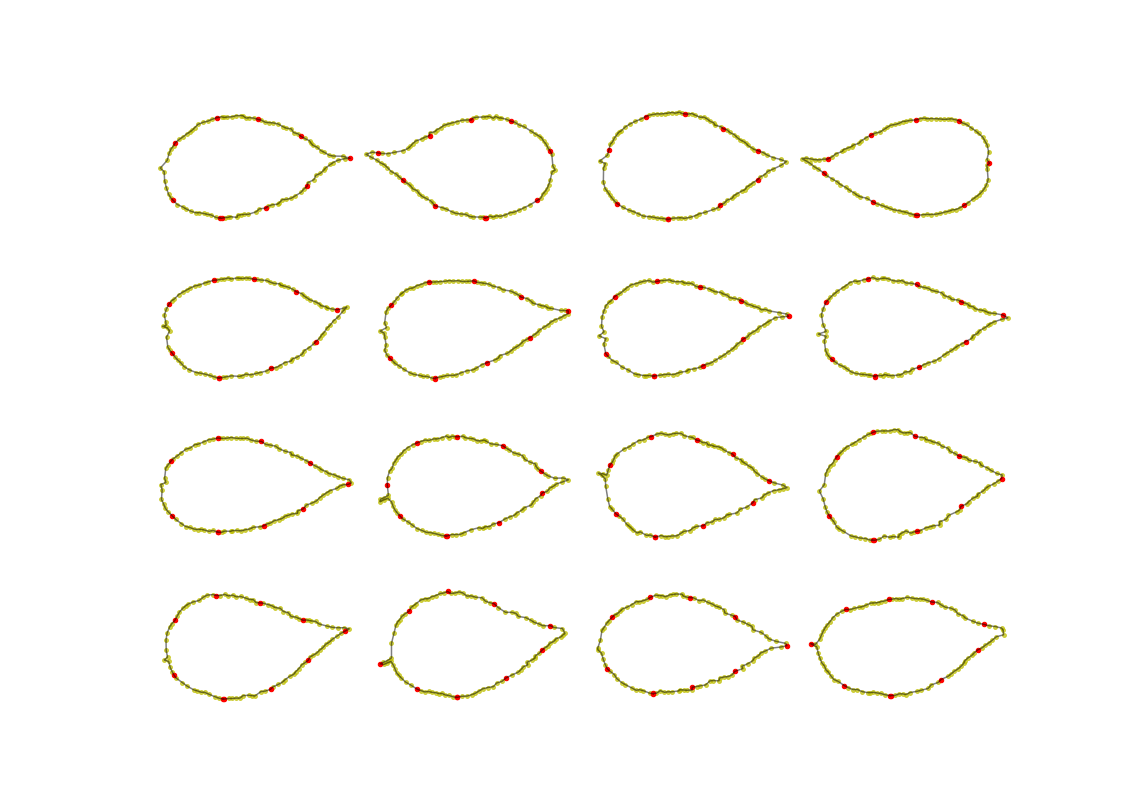

In [62]:
labelList = [1 for i in range(16)]
for j in range(16):
    labelList.append(2)

for label in set(labelList):
    n_col = 4
    idx_class = [labelList[idx]==label for idx in range(len(labelList))]
    idx_class = [i for i, x in enumerate(idx_class) if x]
    M = len(idx_class)
    n_row = int(np.ceil(M/n_col))

    plt.figure(figsize=(20,20))
    ax = plt.subplot(111)
    x_offset = 0.32+0.08*label   # horizontal spacing between curves (may need to adjust)
    y_offset = 0.35    # vertical spacing between curves (may need to adjust)
    plt.setp(ax, 'frame_on', False)
    ax.set_xlim([-0.53,n_col*x_offset])
    ax.set_ylim([-(n_row)*y_offset,y_offset])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid('off')

    idx = 0
    for k in np.arange(0,n_row):
        for l in np.arange(0,n_col):
            ax.plot(exCURVES_truth[idx_class[idx]][0,:]+l*x_offset, exCURVES_truth[idx_class[idx]][1,:]-k*y_offset, c='k', alpha=0.5)
            ax.scatter(exCURVES_truth[idx_class[idx]][0,:]+l*x_offset, exCURVES_truth[idx_class[idx]][1,:]-k*y_offset, c='y', s=15, alpha=0.7)
            ax.scatter(exCURVES_obs[idx_class[idx]][0,:]+l*x_offset, exCURVES_obs[idx_class[idx]][1,:]-k*y_offset, c='r', s=20)
            ax = plt.gca()
            ax.set_aspect('equal', adjustable='box')
            idx = idx+1
            if idx==M:
                break

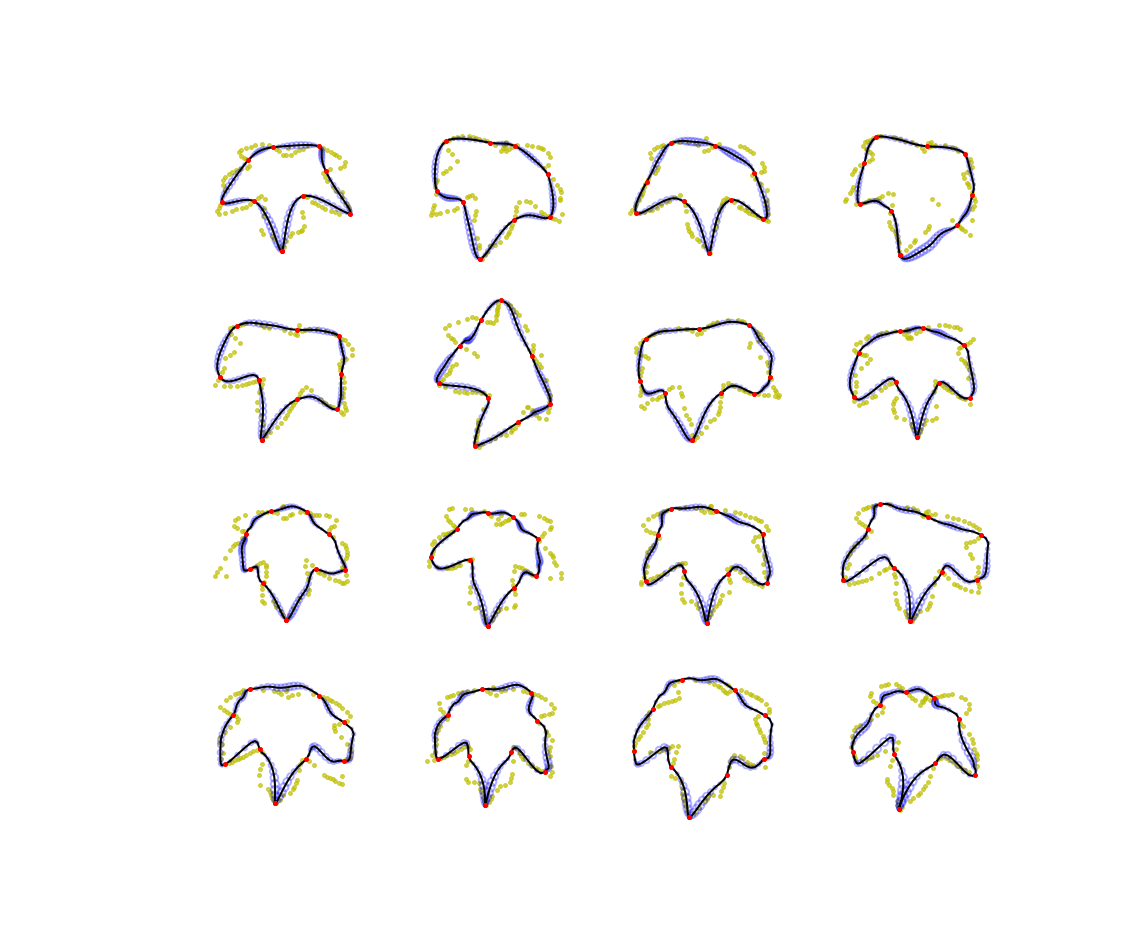

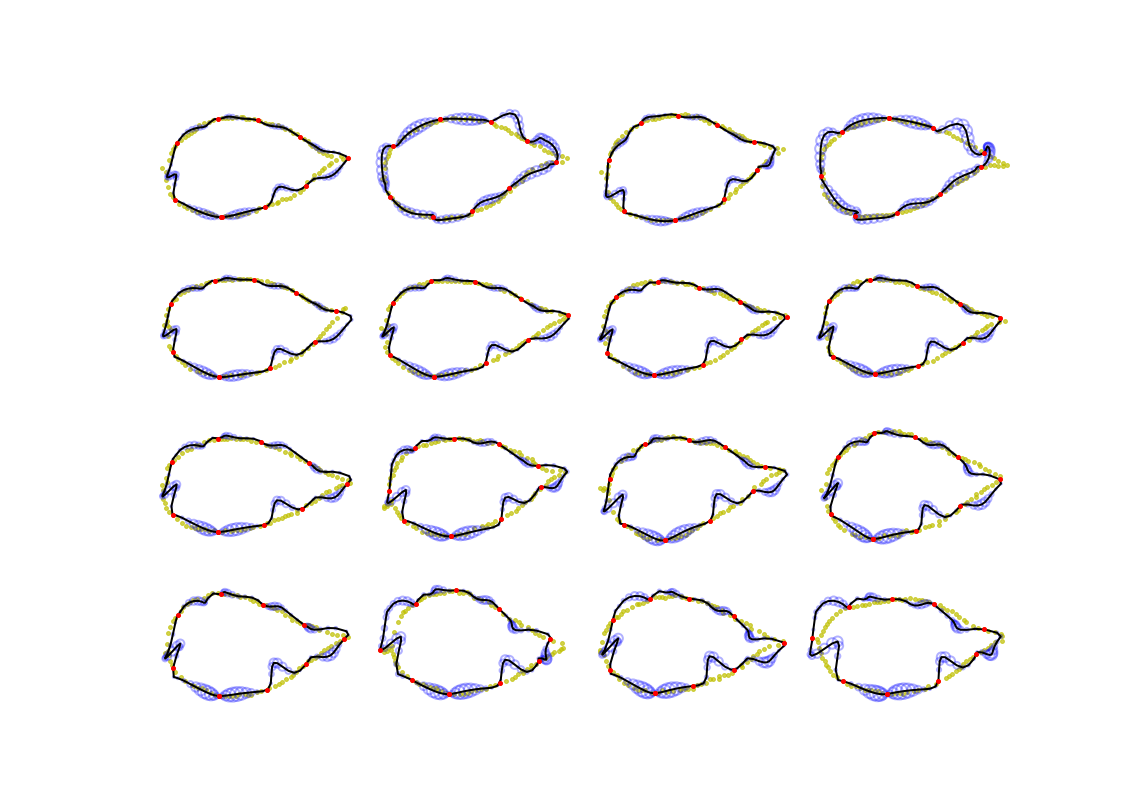

In [63]:
# MOGP fit without labels
MOGP1_fig14 = curveBatchMOGPwithLabel(datapointList=exCURVES_obs, labelList=labelList, truthpointList=exCURVES_truth,
                                      autoEnclose=1, kernel='Matern32', rot=True, cl_kernel='Coreg', nug=1e-2, 
                                      showOutput=False, inc_label=False)

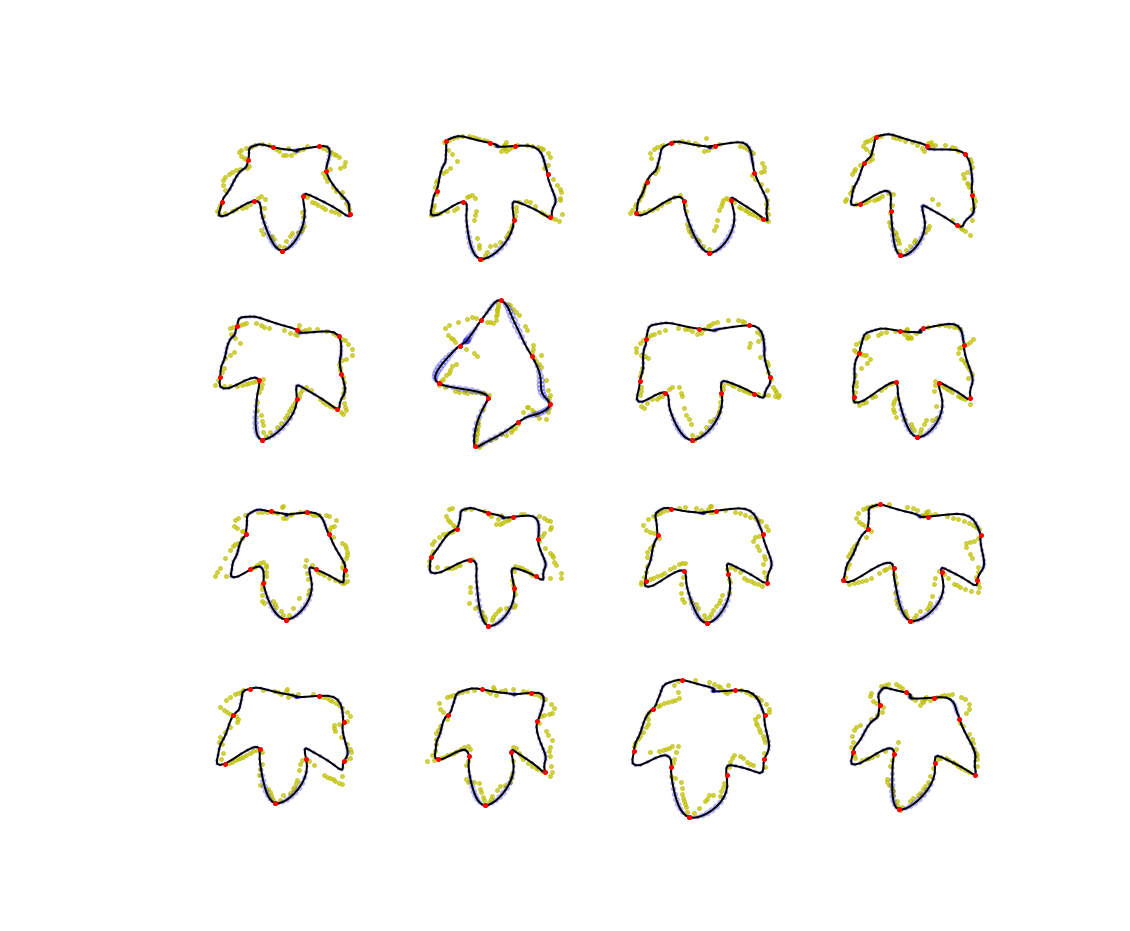

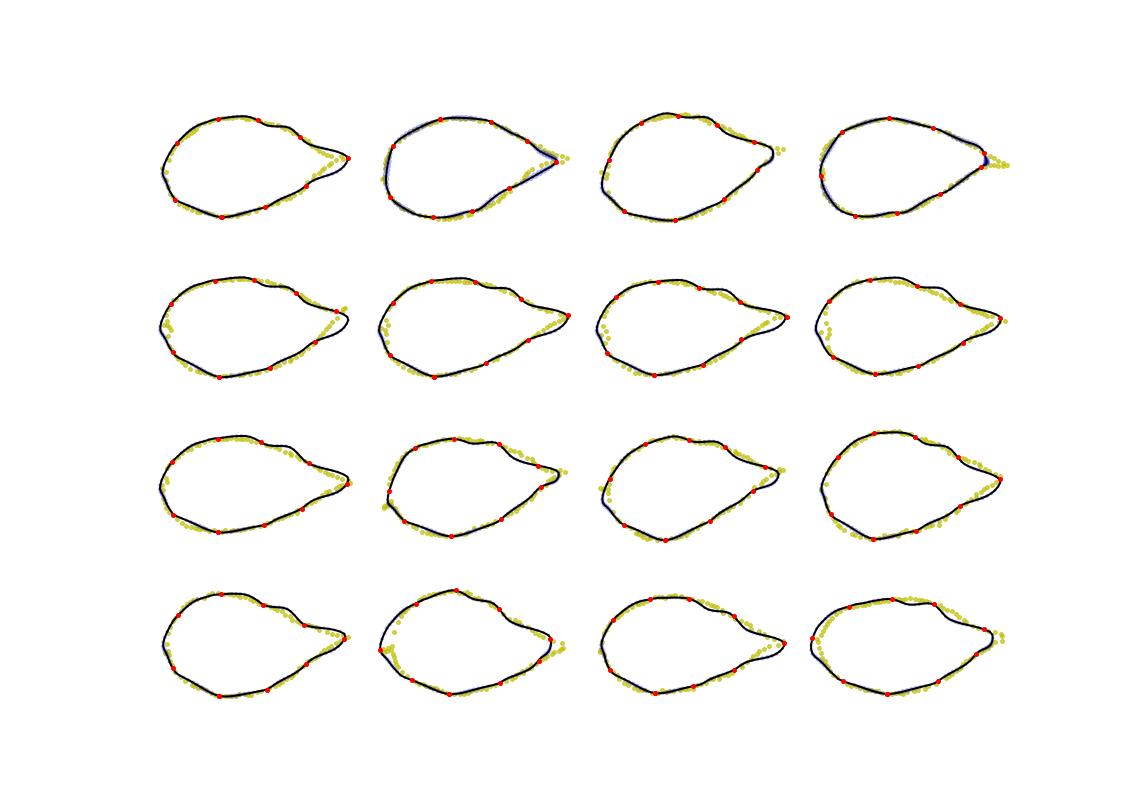

In [64]:
# MOGP fit with labels
MOGP2_fig14 = curveBatchMOGPwithLabel(datapointList=exCURVES_obs, labelList=labelList, truthpointList=exCURVES_truth,
                                      autoEnclose=1, kernel='Matern32', rot=True, cl_kernel='Coreg', nug=1e-2, showOutput=False)

In [65]:
# Evaluate performance metrics, averaged for each class
IMSPE1 = MOGP1_fig14[8]
ESD1 = MOGP1_fig14[9]
IUEA1 = MOGP1_fig14[10]
print(np.mean(IMSPE1[0:16]), np.mean(IMSPE1[16:]))
print(np.mean(ESD1[0:16]), np.mean(ESD1[16:]))
print(np.mean(IUEA1[0:16]), np.mean(IUEA1[16:]))

0.0006609359718090543 0.0005900094363801996
0.4747162519081478 0.40199226367125923
0.00021338177347682738 0.0005158300334368517


In [66]:
# Evaluate performance metrics, averaged for each class
IMSPE2 = MOGP2_fig14[8]
ESD2 = MOGP2_fig14[9]
IUEA2 = MOGP2_fig14[10]
print(np.mean(IMSPE2[0:16]), np.mean(IMSPE2[16:]))
print(np.mean(ESD2[0:16]), np.mean(ESD2[16:]))
print(np.mean(IUEA2[0:16]), np.mean(IUEA2[16:]))

0.0005406979318505602 0.00034088617954416316
0.42309546385245067 0.2491823928307342
5.3283532385472375e-05 5.113577077360826e-05


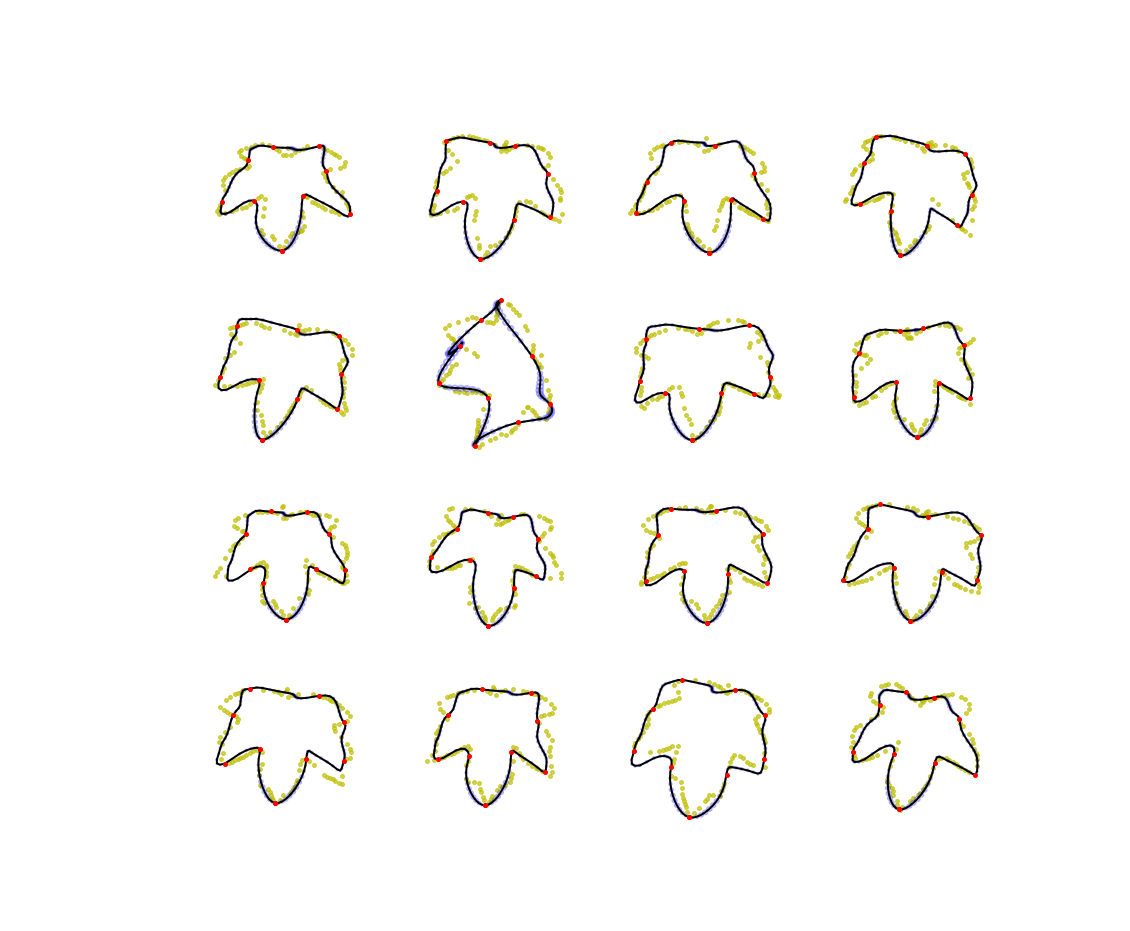

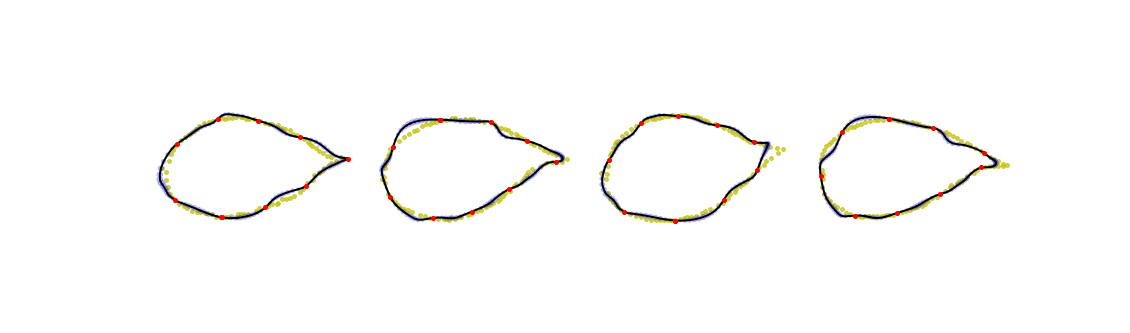

In [67]:
# MOGP fit with labels, unbalanced case
MOGP3_fig14 = curveBatchMOGPwithLabel(datapointList=exCURVES_obs[:20], labelList=labelList[:20], 
                                      truthpointList=exCURVES_truth[:20],
                                      autoEnclose=1, kernel='Matern32', rot=True, cl_kernel='Coreg', nug=1e-2, 
                                      showOutput=False)

### Graphic showing shape-preserving transformations and parameterization-induced correspondences (Figure 9)

In [68]:
# Save curves within specified shape class to a single array, and compute SRVF
# shape_idx - index of shape class (see MPEG_key.txt for index labels)
shape_idx = 23
n = n_o1+1  # number of sample points for each curve when first point = last point (since closed)
beta = np.zeros((d1,n,m1))
beta_sc = np.zeros((d1,n,m1))

# Apply rotation matrix
theta = np.radians(300)
O = np.array(((np.cos(theta),-np.sin(theta)), (np.sin(theta),np.cos(theta))))

# Original curves re-scaled to unit length and (0,0)-centered
for i in range(0,m1):
    beta[:,0:n_o1,i] = np.matmul(O,mpeg_data[shape_idx,i])
    beta[:,n_o1,i] = beta[:,0,i]
    beta_sc[:,:,i] = cf.scale_curve(beta[:,:,i])[0]
    tmp = cf.calculatecentroid(beta_sc[:,:,i])
    beta_sc[:,:,i] = beta_sc[:,:,i]-np.transpose(np.tile(tmp,(n,1)))

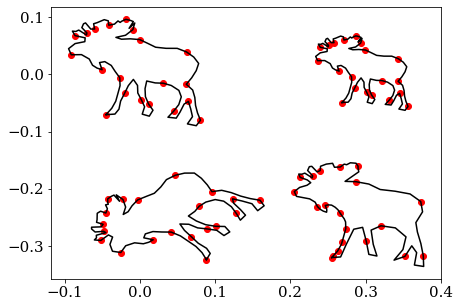

In [69]:
theta = np.radians(60)
O = np.array(((np.cos(theta),-np.sin(theta)), (np.sin(theta),np.cos(theta))))
oc = beta_sc[:,:,10]
ocr =  O@oc
ocp = cf.group_action_by_gamma_coord(oc, gamma=np.linspace(0,1,101)**2)

plt.rcParams["font.family"] = "serif"
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(oc[0,:], oc[1,:], c='k')
ax.plot(0.7*oc[0,:]+0.3, 0.7*oc[1,:], c='k')
ax.plot(ocr[0,:]+0.05, ocr[1,:]-0.25, c='k')
ax.plot(ocp[0,:]+0.3, ocp[1,:]-0.25, c='k')

for i in range(20):
    ax.scatter(oc[0,5*i], oc[1,5*i], c='r')
    ax.scatter(0.7*oc[0,5*i]+0.3, 0.7*oc[1,5*i], c='r')
    ax.scatter(ocr[0,5*i]+0.05, ocr[1,5*i]-0.25, c='r')
    ax.scatter(ocp[0,5*i]+0.3, ocp[1,5*i]-0.25, c='r')

ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)

In [70]:
# Register two deer curves
tmp = cf.find_rotation_and_seed_coord(beta_sc[:,:,0], beta_sc[:,:,5], closed=1, rotation=True, method='DP')
beta_scr = tmp[0]

(-0.10593196876432685,
 0.39237023660545817,
 -0.12665076450509744,
 0.1282465252550775)

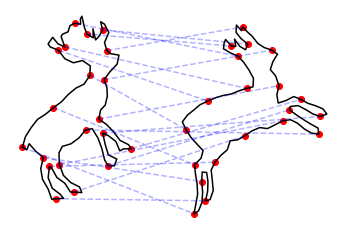

In [71]:
# Arc-length parameterization with correspondence
plt.plot(beta_sc[0,:,0], beta_sc[1,:,0], c='k')
plt.plot(beta_sc[0,:,5]+0.25, beta_sc[1,:,5], c='k')
for i in range(20):
    plt.scatter(beta_sc[0,5*i,0], beta_sc[1,5*i,0], c='r')
    plt.scatter(beta_sc[0,5*i,5]+0.25, beta_sc[1,5*i,5], c='r')
    plt.plot([beta_sc[0,5*i,0],beta_sc[0,5*i,5]+0.25], 
             [beta_sc[1,5*i,0],beta_sc[1,5*i,5]], '--', c='b', alpha=0.3)
plt.axis('off')

(-0.10583626218706445,
 0.3903603984829475,
 -0.13632271911345312,
 0.12870709452214205)

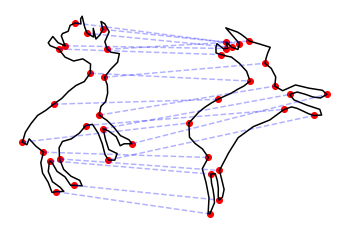

In [72]:
# Elastic parameterization with correspondence
plt.plot(beta_sc[0,:,0], beta_sc[1,:,0], c='k')
plt.plot(beta_scr[0,:]+0.25, beta_scr[1,:], c='k')
for i in range(20):
    plt.scatter(beta_sc[0,5*i,0], beta_sc[1,5*i,0], c='r')
    plt.scatter(beta_scr[0,5*i]+0.25, beta_scr[1,5*i], c='r')
    plt.plot([beta_sc[0,5*i,0],beta_scr[0,5*i]+0.25], 
             [beta_sc[1,5*i,0],beta_scr[1,5*i]], '--', c='b', alpha=0.3)
plt.axis('off')

### Tradeoff between length scale and period hyperparameters (Figure 12)

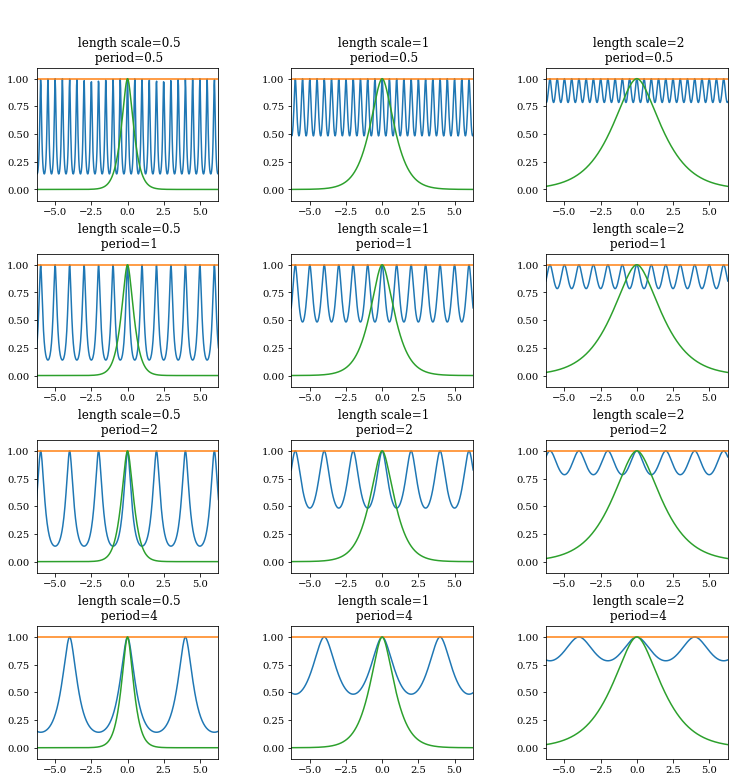

In [73]:
counter = 1
plt.rcParams["font.family"] = "serif"
plt.figure(figsize=(12,12))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

for PERIOD in [0.5,1,2,4]:
    for LENGTHSCALE in [0.5,1,2]:
        my_kern = gpflow.kernels.Periodic(Matern32(active_dims=[0]),\
                      period=PERIOD) +gpflow.kernels.Constant(variance=abs(1e-16)) 
        np_kern = gpflow.kernels.Periodic(Matern32(active_dims=[0]),\
                      period=1e6) +gpflow.kernels.Constant(variance=abs(1e-16)) 
        cm_kern = Matern32(active_dims=[0])+gpflow.kernels.Constant(variance=abs(1e-16)) 
        my_kern.kernels[0].base_kernel.lengthscales = LENGTHSCALE
        my_kern.kernels[0].base_kernel.variance = 1
        
        np_kern.kernels[0].base_kernel.lengthscales = LENGTHSCALE
        np_kern.kernels[0].base_kernel.variance = 1
        
        cm_kern.kernels[0].lengthscales = LENGTHSCALE
        cm_kern.kernels[0].variance = 1

        k = my_kern
        k0 = np_kern
        ku = cm_kern
        
        X1 = np.array([[0.0]])
        X2 = np.linspace(-np.pi*2, np.pi*2, 501).reshape(-1, 1)

        K21 = k(X2, X1)  # cov(f(X2), f(X1)): matrix with shape [101, 1]
        K22 = k(X2)  # equivalent to k(X2, X2) (but more efficient): matrix with shape [101, 101]
        
        K021 = k0(X2, X1)
        K022 = k0(X2)
        
        Ku21 = ku(X2, X1)
        Ku22 = ku(X2)

        plt.subplot(4,3,counter)
        _ = plt.plot(X2, K21,label='periodic')
        _ = plt.plot(X2, K021,label='inf periodic')
        _ = plt.plot(X2, Ku21,label='non-periodic')
        
        plt.title('\n\n length scale='+str(np.round(LENGTHSCALE,2))+'\n period='+str(np.round(PERIOD,2)))
        plt.xlim(-np.pi*2,np.pi*2)
        plt.ylim(-0.1,1.1)
        counter += 1

### Comparing stationary and non-stationary kernel GP fits for dense vs. sparse sampling schemes (Figure 14)

In [74]:
# Save curves within specified shape class to a single array, and compute SRVF
# shape_idx - index of shape class (see MPEG_key.txt for index labels)
shape_idx = 49
n = n_o1+1  # number of sample points for each curve when first point = last point (since closed)
beta = np.zeros((d1,n,m1))
beta_sc = np.zeros((d1,n,m1))

# Apply rotation matrix
theta = np.radians(30)
O = np.array(((np.cos(theta),-np.sin(theta)), (np.sin(theta),np.cos(theta))))

# Original curves re-scaled to unit length and (0,0)-centered
for i in range(0,m1):
    beta[:,0:n_o1,i] = np.matmul(O,mpeg_data[shape_idx,i])
    beta[:,n_o1,i] = beta[:,0,i]
    beta_sc[:,:,i] = cf.scale_curve(beta[:,:,i])[0]
    tmp = cf.calculatecentroid(beta_sc[:,:,i])
    beta_sc[:,:,i] = beta_sc[:,:,i]-np.transpose(np.tile(tmp,(n,1)))

In [75]:
# Prepare data (list format)
exCURVES_obs = []
exCURVES_truth = []

# Curves
N_obs = [10,40]
for i in range(0,2):
    exCURVES_truth.append(beta_sc[:,:,0])
    samp_idx = np.round(np.linspace(0,n_o1,N_obs[i])).astype(int)
    exCURVES_obs.append(beta_sc[:,samp_idx,0])

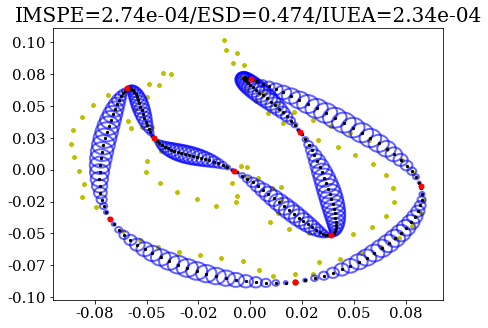

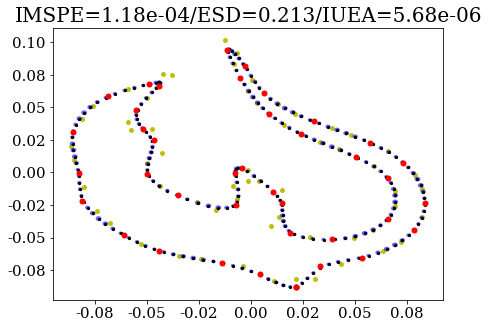

In [76]:
# Stationary kernel fits for sparse and dense observed samples
MOGP_fig18 = []
for i in range(0,2):
    tmp = curveBatchMOGP(datapointList=[exCURVES_obs[i]], predList=200, truthpointList=[exCURVES_truth[i]], cen=True, 
                         scale=True, rot=False, nug=1e-3, showOutput=False, restrict_nv=True, kernel='Matern32')
    MOGP_fig18.append(tmp)

/Users/jstrait/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minimize.py:519: RuntimeWarning: Method COBYLA does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,


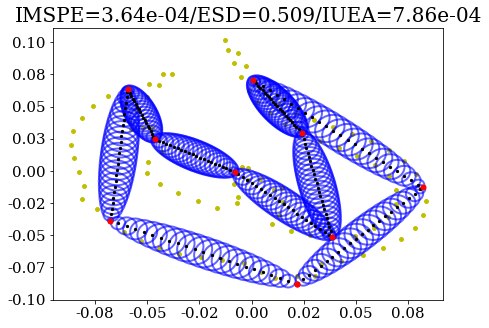

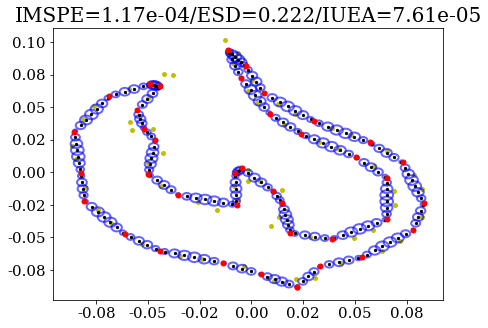

In [77]:
# Non-stationary kernel fits for sparse and dense observed samples
for i in range(0,2):
    tmp = curveBatchMOGP(datapointList=[exCURVES_obs[i]], predList=200, truthpointList=[exCURVES_truth[i]], cen=True, 
                         scale=True, rot=False, nug=1e-3, showOutput=False, restrict_nv=True, kernel='Arccos', 
                         use_Scipy='COBYLA')
    MOGP_fig18.append(tmp)

### Demonstrating numerical invariance of GP fits to the designated "starting point" of a closed curve (an alternative to Figure 16, but not included in current manuscript submission)

In [114]:
# Save curves within specified shape class to a single array, and compute SRVF
# shape_idx - index of shape class (see MPEG_key.txt for index labels)
shape_idx = 0
n = n_o1+1  # number of sample points for each curve when first point = last point (since closed)
beta = np.zeros((d1,n,m1))
beta_sc = np.zeros((d1,n,m1))

# Apply rotation matrix
theta = np.radians(30)
O = np.array(((np.cos(theta),-np.sin(theta)), (np.sin(theta),np.cos(theta))))

# Original curves re-scaled to unit length and (0,0)-centered
for i in range(0,m1):
    beta[:,0:n_o1,i] = np.matmul(O,mpeg_data[shape_idx,i])
    beta[:,n_o1,i] = beta[:,0,i]
    beta_sc[:,:,i] = cf.scale_curve(beta[:,:,i])[0]
    tmp = cf.calculatecentroid(beta_sc[:,:,i])
    beta_sc[:,:,i] = beta_sc[:,:,i]-np.transpose(np.tile(tmp,(n,1)))

In [115]:
## This cell fits a single curve by permuting the starting point amongst the 100 observed sample points, to
## demonstrate invariance of fits to this starting point
## This is omitted in the current manuscript submission, in favor of an alternative demonstration below
# Prepare data (list format)
exCURVES_obs = []
exCURVES_truth = []

# Curves
N_obs = 100
samp_idx = np.round(np.linspace(0,n_o1,N_obs)).astype(int)
tmp = beta_sc[:,samp_idx,0]
tmp_true = beta_sc[:,:,0]
exCURVES_obs.append(tmp)
exCURVES_truth.append(tmp_true)
for i in range(1,N_obs):
    idx = samp_idx[i]
    sp = tmp[:,0].reshape(-1,1)
    tmp = np.hstack((tmp[:,1:],tmp[:,1].reshape(-1,1)))
    exCURVES_obs.append(tmp)
    
    tmp_true_new = copy.deepcopy(tmp_true)
    tmp_true_new = np.hstack((tmp_true_new[:,idx:],tmp_true_new[:,0:idx],tmp_true_new[:,idx].reshape(-1,1)))
    exCURVES_truth.append(tmp_true_new)

In [116]:
MOGP_fig19 = []
for i in range(len(exCURVES_obs)):
    tmp = curveBatchMOGP(datapointList=[exCURVES_obs[i]], predList=100, truthpointList=[exCURVES_truth[i]], cen=True, 
                         scale=True, rot=False, nug=1e-3, showOutput=False, restrict_nv=True, showPlot=False)
    MOGP_fig19.append(tmp)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


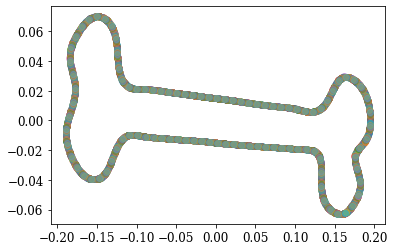

In [117]:
# This just superimposes all the fits
for i in range(len(exCURVES_obs)):
    plt.scatter(MOGP_fig19[i][2][0], MOGP_fig19[i][4][0], alpha=0.3)

In [118]:
# Record kernel hyperparameter estimates for each fit
pk_var = np.zeros((len(exCURVES_obs)))
pk_ls = np.zeros((len(exCURVES_obs)))
pk_per = np.zeros((len(exCURVES_obs)))
D = np.zeros((2,2,len(exCURVES_obs)))

for i in range(len(exCURVES_obs)):
    ker = MOGP_fig19[0][0].kernel
    pk_var[i] = ker.kernels[0].kernels[0].base_kernel.variance.numpy()
    pk_ls[i] = ker.kernels[0].kernels[0].base_kernel.lengthscales.numpy()
    pk_per[i] = ker.kernels[0].kernels[0].period.numpy()
    W = ker.kernels[1].W.numpy()
    kappa = ker.kernels[1].kappa.numpy()
    D[:,:,i] = W*W.T + np.diag(kappa)

### Alternative demonstration of invariance to starting point in terms of both GP fits and hyperparameter estimates (Figures 16-17)

In [119]:
# Save curves within specified shape class to a single array, and compute SRVF
# shape_idx - index of shape class (see MPEG_key.txt for index labels)
shape_idx = 13
n = n_o1+1  # number of sample points for each curve when first point = last point (since closed)
beta = np.zeros((d1,n,m1))
beta_sc = np.zeros((d1,n,m1))

# Apply rotation matrix
theta = np.radians(30)
O = np.array(((np.cos(theta),-np.sin(theta)), (np.sin(theta),np.cos(theta))))

# Original curves re-scaled to unit length and (0,0)-centered
for i in range(0,m1):
    beta[:,0:n_o1,i] = np.matmul(O,mpeg_data[shape_idx,i])
    beta[:,n_o1,i] = beta[:,0,i]
    beta_sc[:,:,i] = cf.scale_curve(beta[:,:,i])[0]
    tmp = cf.calculatecentroid(beta_sc[:,:,i])
    beta_sc[:,:,i] = beta_sc[:,:,i]-np.transpose(np.tile(tmp,(n,1)))

### Periodic kernel -- vary number of observed sample points to draw from over-sampled "true" curve, and randomly generate that number of observed sample points, fit GP, and look at resulting hyperparameter estimates

In [120]:
# Curve settings
N_true = 1000
N_obs = 5
N_rand = 100 # the paper simulations use 1000 for this, but this is more computationally feasible
tmp_orig = cf.resamplecurve(beta_sc[:,:,0], N_true)

# Record kernel hyperparameter estimates for each fit
pk_var1 = np.zeros((N_rand,N_obs))
pk_ls1 = np.zeros((N_rand,N_obs))
pk_per1 = np.zeros((N_rand,N_obs))
D1 = np.zeros((2,2,N_rand,N_obs))

np.random.seed(23)

# Randomly pick N_obs points from N_true
idx = 0
reject = 0
while idx < N_rand:
    samp_idx = np.sort(np.random.choice(N_true, size=N_obs, replace=False))
    tmp = tmp_orig[:,samp_idx]
    tmp = np.hstack((tmp, tmp[:,0].reshape(-1,1)))
    
    fit = []
    for j in range(N_obs):
        if j!=0:
            tmp = np.hstack((tmp[:,1:],tmp[:,1].reshape(-1,1)))
        try:
            fit.append(curveBatchMOGP(datapointList=[tmp], predList=100, cen=True, scale=True, rot=False, nug=1e-3, 
                       showOutput=False, restrict_nv=True, showPlot=False))
        except:
            fit.append(None)
            pass
        
    if fit.count(None)>0:
        #print('rejected')
        reject += 1
        pass
    else:
        for j in range(N_obs):
            ker = fit[j][0].kernel
            pk_var1[idx,j] = ker.kernels[0].kernels[0].base_kernel.variance.numpy()
            pk_ls1[idx,j] = ker.kernels[0].kernels[0].base_kernel.lengthscales.numpy()
            pk_per1[idx,j] = ker.kernels[0].kernels[0].period.numpy()
            W = ker.kernels[1].W.numpy()
            kappa = ker.kernels[1].kappa.numpy()
            D1[:,:,idx,j] = W*W.T + np.diag(kappa)
        
        print(idx+1)
        idx += 1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


In [138]:
# Curve settings
N_true = 1000
N_obs = 20
N_rand = 100 # the paper simulations use 1000 for this, but this is more computationally feasible
tmp_orig = cf.resamplecurve(beta_sc[:,:,0], N_true)

# Record kernel hyperparameter estimates for each fit
pk_var2 = np.zeros((N_rand,N_obs))
pk_ls2 = np.zeros((N_rand,N_obs))
pk_per2 = np.zeros((N_rand,N_obs))
D2 = np.zeros((2,2,N_rand,N_obs))

np.random.seed(27)

# Randomly pick N_obs points from N_true
idx = 0
reject = 0
while idx < N_rand:
    samp_idx = np.sort(np.random.choice(N_true, size=N_obs, replace=False))
    tmp = tmp_orig[:,samp_idx]
    tmp = np.hstack((tmp, tmp[:,0].reshape(-1,1)))
    
    fit = []
    for j in range(N_obs):
        if j!=0:
            tmp = np.hstack((tmp[:,1:],tmp[:,1].reshape(-1,1)))
        try:
            fit.append(curveBatchMOGP(datapointList=[tmp], predList=100, cen=True, scale=True, rot=False, nug=1e-3, 
                       showOutput=False, restrict_nv=True, showPlot=False))
        except:
            fit.append(None)
            pass
        
    if fit.count(None)>0:
        #print('rejected')
        reject += 1
        pass
    else:
        for j in range(N_obs):
            ker = fit[j][0].kernel
            pk_var2[idx,j] = ker.kernels[0].kernels[0].base_kernel.variance.numpy()
            pk_ls2[idx,j] = ker.kernels[0].kernels[0].base_kernel.lengthscales.numpy()
            pk_per2[idx,j] = ker.kernels[0].kernels[0].period.numpy()
            W = ker.kernels[1].W.numpy()
            kappa = ker.kernels[1].kappa.numpy()
            D2[:,:,idx,j] = W*W.T + np.diag(kappa)
        
        print(idx+1)
        idx += 1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


[ 0.08882729 -0.04327944]
[0.06310185 0.07363222]
[-0.04508392 -0.06853023]


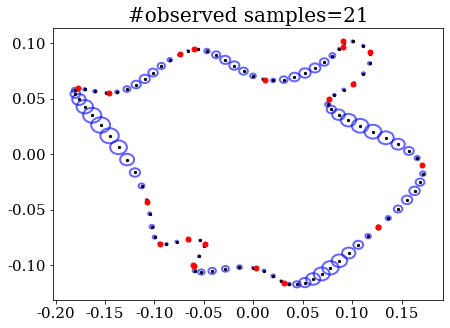

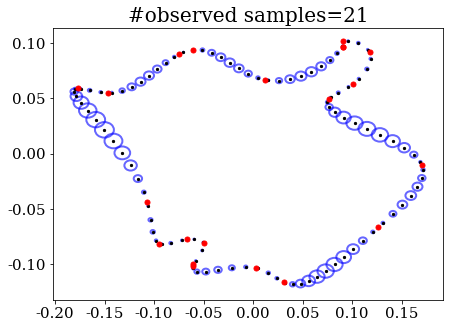

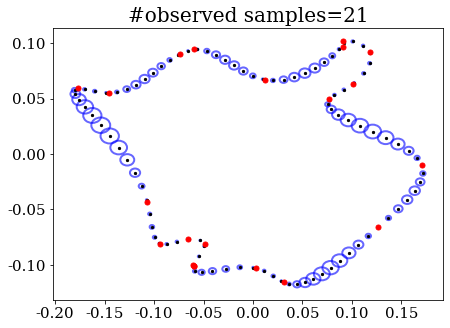

In [139]:
# Plot showing invariance of fits to different starting points
for i in range(20):
    if i!=0:
        tmp = np.hstack((tmp[:,1:],tmp[:,1].reshape(-1,1)))
    if i==1 or i==7 or i==18:
        print(tmp[:,0])
        fit_plot = curveBatchMOGP(datapointList=[tmp], predList=100, cen=True, scale=True, rot=False, nug=1e-3, 
                                  showOutput=False, restrict_nv=True, showPlot=True, showEval=False)

In [122]:
# Curve settings
N_true = 1000
N_obs = 60
N_rand = 100 # the paper simulations use 1000 for this, but this is more computationally feasible
tmp_orig = cf.resamplecurve(beta_sc[:,:,0], N_true)

# Record kernel hyperparameter estimates for each fit
pk_var3 = np.zeros((N_rand,N_obs))
pk_ls3 = np.zeros((N_rand,N_obs))
pk_per3 = np.zeros((N_rand,N_obs))
D3 = np.zeros((2,2,N_rand,N_obs))

np.random.seed(31)

# Randomly pick N_obs points from N_true
idx = 0
reject = 0
while idx < N_rand:
    samp_idx = np.sort(np.random.choice(N_true, size=N_obs, replace=False))
    tmp = tmp_orig[:,samp_idx]
    tmp = np.hstack((tmp, tmp[:,0].reshape(-1,1)))
    
    fit = []
    for j in range(N_obs):
        if j!=0:
            tmp = np.hstack((tmp[:,1:],tmp[:,1].reshape(-1,1)))
        try:
            fit.append(curveBatchMOGP(datapointList=[tmp], predList=100, cen=True, scale=True, rot=False, nug=1e-3, 
                       showOutput=False, restrict_nv=True, showPlot=False))
        except:
            fit.append(None)
            pass
        
    if fit.count(None)>0:
        #print('rejected')
        reject += 1
        pass
    else:
        for j in range(N_obs):
            ker = fit[j][0].kernel
            pk_var3[idx,j] = ker.kernels[0].kernels[0].base_kernel.variance.numpy()
            pk_ls3[idx,j] = ker.kernels[0].kernels[0].base_kernel.lengthscales.numpy()
            pk_per3[idx,j] = ker.kernels[0].kernels[0].period.numpy()
            W = ker.kernels[1].W.numpy()
            kappa = ker.kernels[1].kappa.numpy()
            D3[:,:,idx,j] = W*W.T + np.diag(kappa)
        
        print(idx+1)
        idx += 1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


In [123]:
# Curve settings
N_true = 1000
N_obs = 30
N_rand = 100 # the paper simulations use 1000 for this, but this is more computationally feasible
tmp_orig = cf.resamplecurve(beta_sc[:,:,0], N_true)

# Record kernel hyperparameter estimates for each fit
pk_var4 = np.zeros((N_rand,N_obs))
pk_ls4 = np.zeros((N_rand,N_obs))
pk_per4 = np.zeros((N_rand,N_obs))
D4 = np.zeros((2,2,N_rand,N_obs))

np.random.seed(35)

# Randomly pick N_obs points from N_true
idx = 0
reject = 0
while idx < N_rand:
    samp_idx = np.sort(np.random.choice(N_true, size=N_obs, replace=False))
    tmp = tmp_orig[:,samp_idx]
    tmp = np.hstack((tmp, tmp[:,0].reshape(-1,1)))
    
    fit = []
    for j in range(N_obs):
        if j!=0:
            tmp = np.hstack((tmp[:,1:],tmp[:,1].reshape(-1,1)))
        try:
            fit.append(curveBatchMOGP(datapointList=[tmp], predList=100, cen=True, scale=True, rot=False, nug=1e-3, 
                       showOutput=False, restrict_nv=True, showPlot=False))
        except:
            fit.append(None)
            pass
        
    if fit.count(None)>0:
        #print('rejected')
        reject += 1
        pass
    else:
        for j in range(N_obs):
            ker = fit[j][0].kernel
            pk_var4[idx,j] = ker.kernels[0].kernels[0].base_kernel.variance.numpy()
            pk_ls4[idx,j] = ker.kernels[0].kernels[0].base_kernel.lengthscales.numpy()
            pk_per4[idx,j] = ker.kernels[0].kernels[0].period.numpy()
            W = ker.kernels[1].W.numpy()
            kappa = ker.kernels[1].kappa.numpy()
            D4[:,:,idx,j] = W*W.T + np.diag(kappa)
        
        print(idx+1)
        idx += 1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


In [124]:
# Curve settings
N_true = 1000
N_obs = 45
N_rand = 100 # the paper simulations use 1000 for this, but this is more computationally feasible
tmp_orig = cf.resamplecurve(beta_sc[:,:,0], N_true)

# Record kernel hyperparameter estimates for each fit
pk_var5 = np.zeros((N_rand,N_obs))
pk_ls5 = np.zeros((N_rand,N_obs))
pk_per5 = np.zeros((N_rand,N_obs))
D5 = np.zeros((2,2,N_rand,N_obs))

np.random.seed(39)

# Randomly pick N_obs points from N_true
idx = 0
reject = 0
while idx < N_rand:
    samp_idx = np.sort(np.random.choice(N_true, size=N_obs, replace=False))
    tmp = tmp_orig[:,samp_idx]
    tmp = np.hstack((tmp, tmp[:,0].reshape(-1,1)))
    
    fit = []
    for j in range(N_obs):
        if j!=0:
            tmp = np.hstack((tmp[:,1:],tmp[:,1].reshape(-1,1)))
        try:
            fit.append(curveBatchMOGP(datapointList=[tmp], predList=100, cen=True, scale=True, rot=False, nug=1e-3, 
                       showOutput=False, restrict_nv=True, showPlot=False))
        except:
            fit.append(None)
            pass
        
    if fit.count(None)>0:
        #print('rejected')
        reject += 1
        pass
    else:
        for j in range(N_obs):
            ker = fit[j][0].kernel
            pk_var5[idx,j] = ker.kernels[0].kernels[0].base_kernel.variance.numpy()
            pk_ls5[idx,j] = ker.kernels[0].kernels[0].base_kernel.lengthscales.numpy()
            pk_per5[idx,j] = ker.kernels[0].kernels[0].period.numpy()
            W = ker.kernels[1].W.numpy()
            kappa = ker.kernels[1].kappa.numpy()
            D5[:,:,idx,j] = W*W.T + np.diag(kappa)
        
        print(idx+1)
        idx += 1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


In [125]:
# Pickle to save simulation runs
import pickle
hyp_list = [pk_var1, pk_ls1, pk_per1, D1, pk_var2, pk_ls2, pk_per2, D2, pk_var3, pk_ls3, pk_per3, D3, 
            pk_var4, pk_ls4, pk_per4, D4, pk_var5, pk_ls5, pk_per5, D5]
with open('hyp_list.pkl', 'wb') as f:
    pickle.dump(hyp_list, f)                  

### Non-periodic -- vary number of observed sample points to draw from over-sampled "true" curve, and randomly generate that number of observed sample points, fit GP, and look at resulting hyperparameter estimates

In [126]:
# Curve settings
N_true = 1000
N_obs = 5
N_rand = 100 # the paper simulations use 1000 for this, but this is more computationally feasible
tmp_orig = cf.resamplecurve(beta_sc[:,:,0], N_true)

# Record kernel hyperparameter estimates for each fit
pk_var1n = np.zeros((N_rand,N_obs))
pk_ls1n = np.zeros((N_rand,N_obs))
D1n = np.zeros((2,2,N_rand,N_obs))

np.random.seed(23)

# Randomly pick N_obs points from N_true
idx = 0
reject = 0
while idx < N_rand:
    samp_idx = np.sort(np.random.choice(N_true, size=N_obs, replace=False))
    tmp = tmp_orig[:,samp_idx]
    tmp = np.hstack((tmp, tmp[:,0].reshape(-1,1)))
    
    fit = []
    for j in range(N_obs):
        if j!=0:
            tmp = np.hstack((tmp[:,1:],tmp[:,1].reshape(-1,1)))
        try:
            fit.append(curveBatchMOGP(datapointList=[tmp], predList=100, cen=True, scale=True, rot=False, nug=1e-3, 
                       showOutput=False, restrict_nv=True, showPlot=False, kernel=Matern32(active_dims=[0]),
                       restrictLS=False))
        except:
            fit.append(None)
            pass
        
    if fit.count(None)>0:
        #print('rejected')
        reject += 1
        pass
    else:
        for j in range(N_obs):
            ker = fit[j][0].kernel
            pk_var1n[idx,j] = ker.kernels[0].kernels[0].variance.numpy()
            pk_ls1n[idx,j] = ker.kernels[0].kernels[0].lengthscales.numpy()
            W = ker.kernels[1].W.numpy()
            kappa = ker.kernels[1].kappa.numpy()
            D1n[:,:,idx,j] = W*W.T + np.diag(kappa)
        
        print(idx+1)
        idx += 1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


In [127]:
# Curve settings
N_true = 1000
N_obs = 20
N_rand = 100 # the paper simulations use 1000 for this, but this is more computationally feasible
tmp_orig = cf.resamplecurve(beta_sc[:,:,0], N_true)

# Record kernel hyperparameter estimates for each fit
pk_var2n = np.zeros((N_rand,N_obs))
pk_ls2n = np.zeros((N_rand,N_obs))
D2n = np.zeros((2,2,N_rand,N_obs))

np.random.seed(27)

# Randomly pick N_obs points from N_true
idx = 0
reject = 0
while idx < N_rand:
    samp_idx = np.sort(np.random.choice(N_true, size=N_obs, replace=False))
    tmp = tmp_orig[:,samp_idx]
    tmp = np.hstack((tmp, tmp[:,0].reshape(-1,1)))
    
    fit = []
    for j in range(N_obs):
        if j!=0:
            tmp = np.hstack((tmp[:,1:],tmp[:,1].reshape(-1,1)))
        try:
            fit.append(curveBatchMOGP(datapointList=[tmp], predList=100, cen=True, scale=True, rot=False, nug=1e-3, 
                       showOutput=False, restrict_nv=True, showPlot=False, kernel=Matern32(active_dims=[0]),
                       restrictLS=False))
        except:
            fit.append(None)
            pass
        
    if fit.count(None)>0:
        #print('rejected')
        reject += 1
        pass
    else:
        for j in range(N_obs):
            ker = fit[j][0].kernel
            pk_var2n[idx,j] = ker.kernels[0].kernels[0].variance.numpy()
            pk_ls2n[idx,j] = ker.kernels[0].kernels[0].lengthscales.numpy()
            W = ker.kernels[1].W.numpy()
            kappa = ker.kernels[1].kappa.numpy()
            D2n[:,:,idx,j] = W*W.T + np.diag(kappa)
        
        print(idx+1)
        idx += 1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


In [128]:
# Curve settings
N_true = 1000
N_obs = 60
N_rand = 100 # the paper simulations use 1000 for this, but this is more computationally feasible
tmp_orig = cf.resamplecurve(beta_sc[:,:,0], N_true)

# Record kernel hyperparameter estimates for each fit
pk_var3n = np.zeros((N_rand,N_obs))
pk_ls3n = np.zeros((N_rand,N_obs))
D3n = np.zeros((2,2,N_rand,N_obs))

np.random.seed(31)

# Randomly pick N_obs points from N_true
idx = 0
reject = 0
while idx < N_rand:
    samp_idx = np.sort(np.random.choice(N_true, size=N_obs, replace=False))
    tmp = tmp_orig[:,samp_idx]
    tmp = np.hstack((tmp, tmp[:,0].reshape(-1,1)))
    
    fit = []
    for j in range(N_obs):
        if j!=0:
            tmp = np.hstack((tmp[:,1:],tmp[:,1].reshape(-1,1)))
        try:
            fit.append(curveBatchMOGP(datapointList=[tmp], predList=100, cen=True, scale=True, rot=False, nug=1e-3, 
                       showOutput=False, restrict_nv=True, showPlot=False, kernel=Matern32(active_dims=[0]),
                       restrictLS=False))
        except:
            fit.append(None)
            pass
        
    if fit.count(None)>0:
        #print('rejected')
        reject += 1
        pass
    else:
        for j in range(N_obs):
            ker = fit[j][0].kernel
            pk_var3n[idx,j] = ker.kernels[0].kernels[0].variance.numpy()
            pk_ls3n[idx,j] = ker.kernels[0].kernels[0].lengthscales.numpy()
            W = ker.kernels[1].W.numpy()
            kappa = ker.kernels[1].kappa.numpy()
            D3n[:,:,idx,j] = W*W.T + np.diag(kappa)
        
        print(idx+1)
        idx += 1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


In [129]:
# Pickle to save simulation runs
import pickle
hyp_listn = [pk_var1n, pk_ls1n, D1n, pk_var2n, pk_ls2n, D2n, pk_var3n, pk_ls3n, D3n]
with open('hyp_listn.pkl', 'wb') as f:
    pickle.dump(hyp_listn, f)     

### Plots comparing means and standard deviations of GP fit hyperparameters across simulations between periodic and non-periodic kernels

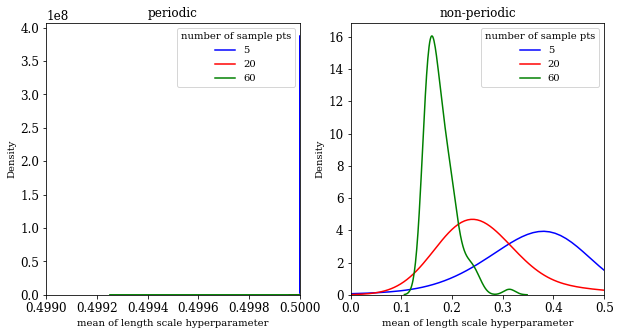

In [131]:
# Mean of length scale
import seaborn as sns
fig, ax = plt.subplots(1,2,figsize=(10,5))
sns.kdeplot(np.mean(pk_ls1, axis=1), color="blue", label="5", ax=ax[0])
sns.kdeplot(np.mean(pk_ls2, axis=1), color="red", label="20", ax=ax[0])
sns.kdeplot(np.mean(pk_ls3, axis=1), color="green", label="60", ax=ax[0])
ax[0].set_title('periodic')
ax[0].set_xlim(0.499,0.5)
ax[0].set_xlabel('mean of length scale hyperparameter')
ax[0].legend(title='number of sample pts')

sns.kdeplot(np.mean(pk_ls1n, axis=1), color="blue", label="5", ax=ax[1])
sns.kdeplot(np.mean(pk_ls2n, axis=1), color="red", label="20", ax=ax[1])
sns.kdeplot(np.mean(pk_ls3n, axis=1), color="green", label="60", ax=ax[1])
ax[1].set_title('non-periodic')
ax[1].set_xlim(0,0.5)
ax[1].set_xlabel('mean of length scale hyperparameter')
ax[1].legend(title='number of sample pts')

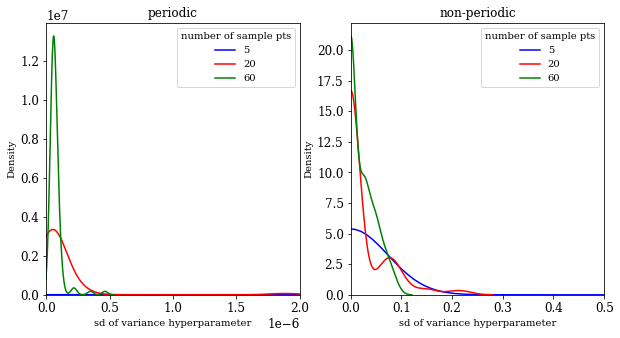

In [132]:
# SD of variance
import seaborn as sns
fig, ax = plt.subplots(1,2,figsize=(10,5))
sns.kdeplot(np.std(pk_var1, axis=1), color="blue", label="5", ax=ax[0])
sns.kdeplot(np.std(pk_var2, axis=1), color="red", label="20", ax=ax[0])
sns.kdeplot(np.std(pk_var3, axis=1), color="green", label="60", ax=ax[0])
ax[0].set_title('periodic')
ax[0].set_xlim(0,2e-6)
ax[0].set_xlabel('sd of variance hyperparameter')
ax[0].legend(title='number of sample pts')

sns.kdeplot(np.std(pk_var1n, axis=1), color="blue", label="5", ax=ax[1])
sns.kdeplot(np.std(pk_var2n, axis=1), color="red", label="20", ax=ax[1])
sns.kdeplot(np.std(pk_var3n, axis=1), color="green", label="60", ax=ax[1])
ax[1].set_title('non-periodic')
ax[1].set_xlim(0,0.5)
ax[1].set_xlabel('sd of variance hyperparameter')
ax[1].legend(title='number of sample pts')

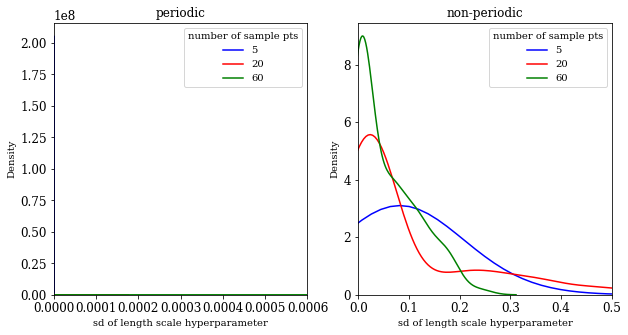

In [133]:
# SD of length scale
fig, ax = plt.subplots(1,2,figsize=(10,5))
sns.kdeplot(np.std(pk_ls1, axis=1), color="blue", label="5", ax=ax[0])
sns.kdeplot(np.std(pk_ls2, axis=1), color="red", label="20", ax=ax[0])
sns.kdeplot(np.std(pk_ls3, axis=1), color="green", label="60", ax=ax[0])
ax[0].set_title('periodic')
ax[0].set_xlim(0,6e-4)
ax[0].set_xlabel('sd of length scale hyperparameter')
ax[0].legend(title='number of sample pts')

sns.kdeplot(np.std(pk_ls1n, axis=1), color="blue", label="5", ax=ax[1])
sns.kdeplot(np.std(pk_ls2n, axis=1), color="red", label="20", ax=ax[1])
sns.kdeplot(np.std(pk_ls3n, axis=1), color="green", label="60", ax=ax[1])
ax[1].set_title('non-periodic')
ax[1].set_xlim(0,0.5)
ax[1].set_xlabel('sd of length scale hyperparameter')
ax[1].legend(title='number of sample pts')

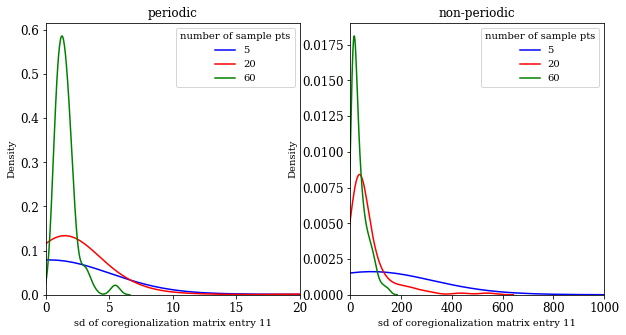

In [134]:
# SD of coregionalization matrix entry (1,1)
fig, ax = plt.subplots(1,2,figsize=(10,5))
sns.kdeplot(np.std(D1[0,0,:], axis=1), color="blue", label="5", ax=ax[0])
sns.kdeplot(np.std(D2[0,0,:], axis=1), color="red", label="20", ax=ax[0])
sns.kdeplot(np.std(D3[0,0,:], axis=1), color="green", label="60", ax=ax[0])
ax[0].set_title('periodic')
ax[0].set_xlim(0,20)
ax[0].set_xlabel('sd of coregionalization matrix entry 11')
ax[0].legend(title='number of sample pts')

sns.kdeplot(np.std(D1n[0,0,:], axis=1), color="blue", label="5", ax=ax[1])
sns.kdeplot(np.std(D2n[0,0,:], axis=1), color="red", label="20", ax=ax[1])
sns.kdeplot(np.std(D3n[0,0,:], axis=1), color="green", label="60", ax=ax[1])
ax[1].set_title('non-periodic')
ax[1].set_xlim(0,1000)
ax[1].set_xlabel('sd of coregionalization matrix entry 11')
ax[1].legend(title='number of sample pts')

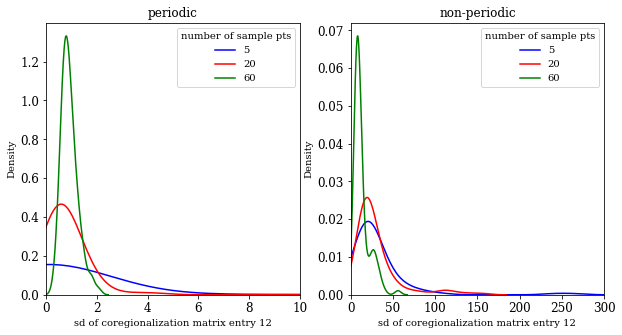

In [135]:
# SD of coregionalization matrix entry (1,2) (between-coordinate dependence)
fig, ax = plt.subplots(1,2,figsize=(10,5))
sns.kdeplot(np.std(D1[0,1,:], axis=1), color="blue", label="5", ax=ax[0])
sns.kdeplot(np.std(D2[0,1,:], axis=1), color="red", label="20", ax=ax[0])
sns.kdeplot(np.std(D3[0,1,:], axis=1), color="green", label="60", ax=ax[0])
ax[0].set_title('periodic')
ax[0].set_xlim(0,10)
ax[0].set_xlabel('sd of coregionalization matrix entry 12')
ax[0].legend(title='number of sample pts')

sns.kdeplot(np.std(D1n[0,1,:], axis=1), color="blue", label="5", ax=ax[1])
sns.kdeplot(np.std(D2n[0,1,:], axis=1), color="red", label="20", ax=ax[1])
sns.kdeplot(np.std(D3n[0,1,:], axis=1), color="green", label="60", ax=ax[1])
ax[1].set_title('non-periodic')
ax[1].set_xlim(0,300)
ax[1].set_xlabel('sd of coregionalization matrix entry 12')
ax[1].legend(title='number of sample pts')

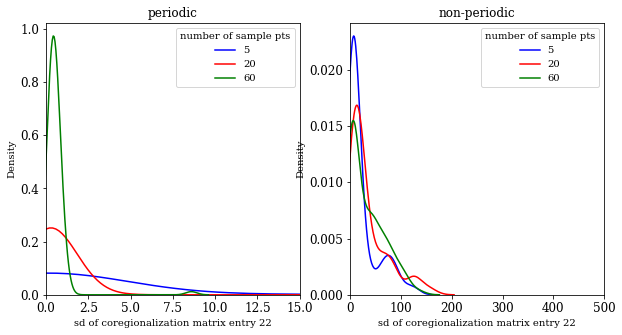

In [136]:
# SD of coregionalization entry (2,2)
fig, ax = plt.subplots(1,2,figsize=(10,5))
sns.kdeplot(np.std(D1[1,1,:], axis=1), color="blue", label="5", ax=ax[0])
sns.kdeplot(np.std(D2[1,1,:], axis=1), color="red", label="20", ax=ax[0])
sns.kdeplot(np.std(D3[1,1,:], axis=1), color="green", label="60", ax=ax[0])
ax[0].set_title('periodic')
ax[0].set_xlim(0,15)
ax[0].set_xlabel('sd of coregionalization matrix entry 22')
ax[0].legend(title='number of sample pts')

sns.kdeplot(np.std(D1n[1,1,:], axis=1), color="blue", label="5", ax=ax[1])
sns.kdeplot(np.std(D2n[1,1,:], axis=1), color="red", label="20", ax=ax[1])
sns.kdeplot(np.std(D3n[1,1,:], axis=1), color="green", label="60", ax=ax[1])
ax[1].set_title('non-periodic')
ax[1].set_xlim(0,500)
ax[1].set_xlabel('sd of coregionalization matrix entry 22')
ax[1].legend(title='number of sample pts')

### Showing possible issues in mapping between curve and its square-root velocity function representation (SRVF) in the fdasrsf module (Figure 19)

In [78]:
# Save curves within specified shape class to a single array, and compute SRVF
# shape_idx - index of shape class (see MPEG_key.txt for index labels)
shape_idx = 24
n = n_o1+1  # number of sample points for each curve when first point = last point (since closed)
beta = np.zeros((d1,n,m1))
beta_sc = np.zeros((d1,n,m1))

# Apply rotation matrix
theta = np.radians(30)
O = np.array(((np.cos(theta),-np.sin(theta)), (np.sin(theta),np.cos(theta))))

# Original curves re-scaled to unit length and (0,0)-centered
for i in range(0,m1):
    beta[:,0:n_o1,i] = np.matmul(O,mpeg_data[shape_idx,i])
    beta[:,n_o1,i] = beta[:,0,i]
    beta_sc[:,:,i] = cf.scale_curve(beta[:,:,i])[0]
    tmp = cf.calculatecentroid(beta_sc[:,:,i])
    beta_sc[:,:,i] = beta_sc[:,:,i]-np.transpose(np.tile(tmp,(n,1)))

In [79]:
# Prepare data (list format)
exCURVES_truth = []
exCURVES_obs = []

# Curves with additional Bernoulli noise
curve_idx = 5
tmp = beta_sc[:,:,curve_idx]
exCURVES_truth.append(tmp)
    
# Add Bernoulli noise along each coordinate to true curve to obtain observed
np.random.seed(1340)
tmp2 = copy.deepcopy(tmp)
for t in range(0,n_o1):
    noise_ind = np.random.binomial(n=1, p=1, size=2)
    if noise_ind[0]==1:
        tmp2[0,t] = tmp2[0,t] + np.random.normal(loc=0, scale=0.005, size=1)
    if noise_ind[1]==1:
        tmp2[1,t] = tmp2[1,t] + np.random.normal(loc=0, scale=0.0025, size=1)     
tmp2[:,-1] = tmp2[:,0]

# Sample to different number of equally-spaced points
N_obs = 25
pt_idx = np.round(np.linspace(0,n_o1,N_obs)).astype(int)
tmp_obs = beta_sc[:,pt_idx,curve_idx]
exCURVES_obs.append(tmp_obs)

theta = np.radians(0)
O = np.array(((np.cos(theta),-np.sin(theta)), (np.sin(theta),np.cos(theta))))

tmp3 = tmp2[:,pt_idx]
exCURVES_obs.append(O@tmp3)

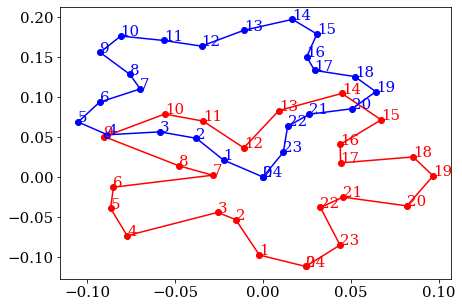

In [80]:
beta_rs = np.zeros((2,N_obs,len(exCURVES_obs)))
for m in range(0,len(exCURVES_obs)):
    beta_rs[:,:,m] = exCURVES_obs[m]
    
res0 = beta_rs[:,:,1]
res1 = cf.curve_to_q( res0, mode = 'C') 
res2 = cf.q_to_curve( res1[0], scale = res1[1])

plt.rcParams["font.family"] = "serif"
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(res0[0,:],res0[1,:],'o-',color='red',label='original')
ax.plot(res2[0,:],res2[1,:],'o-',color='blue',label='q_to_curve(curve_to_q(*))')
for i in range(res0.shape[1]):
    ax.annotate(str(i),(res0[0,i],res0[1,i]),color='red',size=15)
    ax.annotate(str(i),(res2[0,i],res2[1,i]),color='blue',size=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)

In [81]:
# Prepare data (list format)
exCURVES_truth = []
exCURVES_obs = []

# Curves with additional Bernoulli noise
curve_idx = 5
tmp = beta_sc[:,:,curve_idx]
exCURVES_truth.append(tmp)
    
# Add Bernoulli noise along each coordinate to true curve to obtain observed
np.random.seed(1340)
tmp2 = copy.deepcopy(tmp)
for t in range(0,n_o1):
    noise_ind = np.random.binomial(n=1, p=1, size=2)
    if noise_ind[0]==1:
        tmp2[0,t] = tmp2[0,t] + np.random.normal(loc=0, scale=0.008, size=1)
    if noise_ind[1]==1:
        tmp2[1,t] = tmp2[1,t] + np.random.normal(loc=0, scale=0.008, size=1)     
tmp2[:,-1] = tmp2[:,0]

# Sample to different number of equally-spaced points
N_obs = 101
pt_idx = np.round(np.linspace(0,n_o1,N_obs)).astype(int)
tmp_obs = beta_sc[:,pt_idx,curve_idx]
exCURVES_obs.append(tmp_obs)

theta = np.radians(0)
O = np.array(((np.cos(theta),-np.sin(theta)), (np.sin(theta),np.cos(theta))))

tmp3 = tmp2[:,pt_idx]
exCURVES_obs.append(O@tmp3)

In [82]:
# Elastic registration of curves based on observed sample points
beta_rs = np.zeros((2,N_obs,len(exCURVES_obs)))
for m in range(0,len(exCURVES_obs)):
    beta_rs[:,:,m] = exCURVES_obs[m]

er_obs = fdacurve_v2(beta_rs, mode='C', N=N_obs, scale=False)
q_rs = er_obs.q

q2best, Rbest, gamIbest, ctrbest = find_rotation_and_seed_unique_warpv2(q_rs[:,:,0], q_rs[:,:,0], closed=1, 
                                                                        rotation=True, method='DP')
beta_new = cf.q_to_curve(q2best)

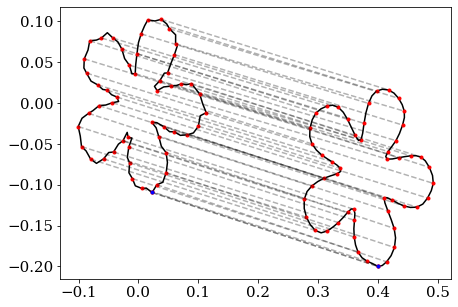

In [83]:
# Plot of registered curves based on observed sample points
x_offset = 0.4
y_offset = 0.2

plt.rcParams["font.family"] = "serif"
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(beta_rs[0,:,0], beta_rs[1,:,0], c='k')
ax.plot(beta_new[0,:]+x_offset, beta_new[1,:]-y_offset, c='k')
for i in range(0,N_obs):
    if i%2==0:
        ax.plot(beta_rs[0,i,0], beta_rs[1,i,0], c='r', marker='.')
        ax.plot(beta_new[0,i]+x_offset, beta_new[1,i]-y_offset, c='r', marker='.')
        ax.plot([beta_rs[0,i,0],beta_new[0,i]+x_offset], [beta_rs[1,i,0],beta_new[1,i]-y_offset], c='k', linestyle='dashed', alpha=0.3)
ax.plot(beta_rs[0,0,0], beta_rs[1,0,0], c='b', marker='.')
ax.plot(beta_new[0,0]+x_offset, beta_new[1,0]-y_offset, c='b', marker='.') 
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)